In [7]:
import albumentations as A
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os, gc, random, time, timm, math
import pandas as pd
import torch
import torch.nn as nn

from albumentations.pytorch import ToTensorV2
from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List

from scipy.signal import butter, lfilter, freqz
from scipy.stats import entropy
from scipy.special import rel_entr

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')
train_mode = True

Using 1 GPU(s)


In [8]:
class config:
    AMP = True
    BATCH_SIZE = 8 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    EPOCHS = 10 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    FOLDS = 5
    FREEZE = False
    GRADIENT_ACCUMULATION_STEPS = 1
    MAX_GRAD_NORM = 1e7
    MODEL = "tf_efficientnet_b2" #"tf_efficientnet_b0"
    NUM_FROZEN_LAYERS = 39
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 50
    SEED = 2024
    TRAIN_FULL_DATA = False
    VISUALIZE = True
    WEIGHT_DECAY = 0.01
    SAMPLE = 5
    STAGE_2 = False
    
class paths:
    OUTPUT_DIR = "./outputs/"
    PRE_LOADED_EEGS = './inputs/brain-eeg-spectrograms/eeg_specs.npy'
    PRE_LOADED_SPECTROGRAMS = './inputs/brain-spectrograms/specs.npy'
    TRAIN_CSV = "./inputs/hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = "./inputs/hms-harmful-brain-activity-classification/train_eegs"
    TRAIN_SPECTROGRAMS = "./inputs/hms-harmful-brain-activity-classification/train_spectrograms"
    TEST_CSV = "./inputs/hms-harmful-brain-activity-classification/test.csv"
    TEST_SPECTROGRAMS = "./inputs/hms-harmful-brain-activity-classification/test_spectrograms"
    TEST_EEGS = "./inputs/hms-harmful-brain-activity-classification/test_eegs"
    
class CFG:
    VERSION = 88

    model_name = "resnet1d_gru"

    seed = 2024
    batch_size = 32
    num_workers = 0

    fixed_kernel_size = 5
    # kernels = [3, 5, 7, 9]
    # linear_layer_features = 424
    kernels = [3, 5, 7, 9, 11]
    #linear_layer_features = 448  # Full Signal = 10_000
    #linear_layer_features = 352  # Half Signal = 5_000
    linear_layer_features = 304   # 1/5  Signal = 2_000

    seq_length = 50  # Second's
    sampling_rate = 200  # Hz
    nsamples = seq_length * sampling_rate  # Число семплов
    out_samples = nsamples // 5

    # bandpass_filter = {"low": 0.5, "high": 20, "order": 2}
    # rand_filter = {"probab": 0.1, "low": 10, "high": 20, "band": 1.0, "order": 2}
    freq_channels = []  # [(8.0, 12.0)]; [(0.5, 4.5)]
    filter_order = 2
    random_close_zone = 0.0  # 0.2
        
    target_cols = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]

    # target_preds = [x + "_pred" for x in target_cols]
    # label_to_num = {"Seizure": 0, "LPD": 1, "GPD": 2, "LRDA": 3, "GRDA": 4, "Other": 5}
    # num_to_label = {v: k for k, v in label_to_num.items()}

    map_features = [
        ("Fp1", "T3"),
        ("T3", "O1"),
        ("Fp1", "C3"),
        ("C3", "O1"),
        ("Fp2", "C4"),
        ("C4", "O2"),
        ("Fp2", "T4"),
        ("T4", "O2"),
        #('Fz', 'Cz'), ('Cz', 'Pz'),        
    ]

    eeg_features = ["Fp1", "T3", "C3", "O1", "Fp2", "C4", "T4", "O2"]  # 'Fz', 'Cz', 'Pz']
        # 'F3', 'P3', 'F7', 'T5', 'Fz', 'Cz', 'Pz', 'F4', 'P4', 'F8', 'T6', 'EKG']                    
    feature_to_index = {x: y for x, y in zip(eeg_features, range(len(eeg_features)))}
    simple_features = []  # 'Fz', 'Cz', 'Pz', 'EKG'

    # eeg_features = [row for row in feature_to_index]
    # eeg_feat_size = len(eeg_features)
    
    n_map_features = len(map_features)
    in_channels = n_map_features + n_map_features * len(freq_channels) + len(simple_features)
    target_size = len(target_cols)
    
    # PATH = "/kaggle/input/hms-harmful-brain-activity-classification/"
    # train_eeg = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/"
    # test_eeg = "/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/"
    # test_csv = "/kaggle/input/hms-harmful-brain-activity-classification/test.csv"
    # train_csv = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"

In [9]:
koef_1 = 1.0
model_weights = [
    {
        'bandpass_filter':{'low':0.5, 'high':20, 'order':2}, 
        'file_data': 
        [
            #{'koef':koef_1, 'file_mask':"/kaggle/input/hms-resnet1d-gru-weights-v82/pop_1_weight_oof/*_best.pth"},
            {'koef':koef_1, 'file_mask':"/kaggle/input/hms-resnet1d-gru-weights-v82/pop_2_weight_oof/*_best.pth"},
        ]
    },
]
model_block = model_weights[0]

# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def plot_spectrogram(spectrogram_path: str):
    """
    Source: https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey
    Visualize spectogram recordings from a parquet file.
    :param spectrogram_path: path to the spectogram parquet.
    """
    sample_spect = pd.read_parquet(spectrogram_path)
    
    split_spect = {
        "LL": sample_spect.filter(regex='^LL', axis=1),
        "RL": sample_spect.filter(regex='^RL', axis=1),
        "RP": sample_spect.filter(regex='^RP', axis=1),
        "LP": sample_spect.filter(regex='^LP', axis=1),
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axes = axes.flatten()
    label_interval = 5
    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        img = ax.imshow(np.log(split_spect[split_name]).T, cmap='viridis', aspect='auto', origin='lower')
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Log(Value)')
        ax.set_title(split_name)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time")

        ax.set_yticks(np.arange(len(split_spect[split_name].columns)))
        ax.set_yticklabels([column_name[3:] for column_name in split_spect[split_name].columns])
        frequencies = [column_name[3:] for column_name in split_spect[split_name].columns]
        ax.set_yticks(np.arange(0, len(split_spect[split_name].columns), label_interval))
        ax.set_yticklabels(frequencies[::label_interval])
    plt.tight_layout()
    plt.show()
    
    
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 

    
def sep():
    print("-"*100)
    
def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x  # quantized


def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x


def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s


def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype="band")

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_lowpass_filter(
    data, cutoff_freq=20, sampling_rate=CFG.sampling_rate, order=4
):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


def denoise_filter(x):
    # Частота дискретизации и желаемые частоты среза (в Гц).
    # Отфильтруйте шумный сигнал
    y = butter_bandpass_filter(x, CFG.lowcut, CFG.highcut, CFG.sampling_rate, order=6)
    y = (y + np.roll(y, -1) + np.roll(y, -2) + np.roll(y, -3)) / 4
    y = y[0:-1:4]
    return y


target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
LOGGER = get_logger()
seed_everything(config.SEED)

# Parquet to EEG Signals Numpy Processing

In [11]:
def eeg_from_parquet(
    parquet_path: str, display: bool = False, seq_length=CFG.seq_length
) -> np.ndarray:
    """
    Эта функция читает файл паркета и извлекает средние 50 секунд показаний. Затем он заполняет значения NaN
    со средним значением (игнорируя NaN).
        :param parquet_path: путь к файлу паркета.
        :param display: отображать графики ЭЭГ или нет.
        :return data: np.array формы (time_steps, eeg_features) -> (10_000, 8)
    """

    # Вырезаем среднюю 50 секундную часть
    eeg = pd.read_parquet(parquet_path, columns=CFG.eeg_features)
    rows = len(eeg)

    # начало смещения данных, чтобы забрать середину
    offset = (rows - CFG.nsamples) // 2

    # средние 50 секунд, имеет одинаковое количество показаний слева и справа
    eeg = eeg.iloc[offset : offset + CFG.nsamples]

    if display:
        plt.figure(figsize=(10, 5))
        offset = 0

    # Конвертировать в numpy

    # создать заполнитель той же формы с нулями
    data = np.zeros((CFG.nsamples, len(CFG.eeg_features)))

    for index, feature in enumerate(CFG.eeg_features):
        x = eeg[feature].values.astype("float32")  # конвертировать в float32

        # Вычисляет среднее арифметическое вдоль указанной оси, игнорируя NaN.
        mean = np.nanmean(x)
        nan_percentage = np.isnan(x).mean()  # percentage of NaN values in feature

        # Заполнение значения Nan
        # Поэлементная проверка на NaN и возврат результата в виде логического массива.
        if nan_percentage < 1:  # если некоторые значения равны Nan, но не все
            x = np.nan_to_num(x, nan=mean)
        else:  # если все значения — Nan
            x[:] = 0
        data[:, index] = x

        if display:
            if index != 0:
                offset += x.max()
            plt.plot(range(CFG.nsamples), x - offset, label=feature)
            offset -= x.min()

    if display:
        plt.legend()
        name = parquet_path.split("/")[-1].split(".")[0]
        plt.yticks([])
        plt.title(f"EEG {name}", size=16)
        plt.show()
    return data

In [16]:
if train_mode:
    train_df = pd.read_csv(paths.TRAIN_CSV)
    print(f"Train dataframe shape is: {train_df.shape}")
    train_df.head()

Train dataframe shape is: (106800, 15)


In [19]:
if train_mode:
    train_eeg_parquet_paths = glob(paths.TRAIN_EEGS + "/*.parquet")
    train_eeg_df = pd.read_parquet(train_eeg_parquet_paths[0])
    train_eeg_features = train_eeg_df.columns
    print(f"There are {len(train_eeg_features)} raw eeg features")
    print(list(train_eeg_features))
    del train_eeg_df
    _ = gc.collect()

    # %%time
    all_eegs = {}
    eeg_ids = train_df.eeg_id.unique()
    for i, eeg_id in tqdm(enumerate(eeg_ids), total=len(eeg_ids)):
        # Save EEG to Python dictionary of numpy arrays
        eeg_path = paths.TRAIN_EEGS + "/" + str(eeg_id) + ".parquet"
        data = eeg_from_parquet(eeg_path)
        all_eegs[eeg_id] = data

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


100%|██████████| 17089/17089 [01:47<00:00, 159.68it/s]


# <b><span style='color:#F1A424'>|</span> Load Data \& Preprocess</b><a class='anchor' id='load_data'></a> [↑](#top) 

The competition data description says that test data does not have multiple crops from the same `eeg_id`. Therefore we will train and validate using only 1 crop per `eeg_id`. There is a discussion about this [here][1].

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [20]:
from scipy.stats import entropy
from scipy.special import rel_entr
def cal_entropy(row, tgt_list):
    uniform_list = [1/6 for i in range(6)]
    return sum(rel_entr(uniform_list, row[tgt_list].astype('float32').values + 1e-5))
def get_non_overlap(df_csv, targets):
    # Reference Discussion:
    # https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

    # train and validate using only 1 crop per eeg_id
    # same results as Chris's notebook

    tgt_list = targets.tolist()

    agg_dict = {
        'spectrogram_id': 'first',
        'spectrogram_label_offset_seconds': ['min', 'max'],
        'patient_id': 'first',
    }
    # use more data
    for t in tgt_list:
        agg_dict[t] = 'sum'

    agg_dict['expert_consensus'] = 'first'
    agg_dict['entropy'] = 'mean'
    agg_dict['total_votes'] = 'sum'

    train = df_csv.groupby(['eeg_id']).agg(agg_dict)
    train.columns = ['_'.join(col).strip() for col in train.columns.values]
    train.columns = ['spectrogram_id', 'min', 'max', 'patient_id'] + tgt_list + ['target', "entropy", "total_votes"]
    # train.columns = ['spectrogram_id', 'min', 'max', 'patient_id'] + ['target']

    train[tgt_list] = train[tgt_list].div(train['total_votes'], axis='index')
    train = train.reset_index(drop=False)
    # train["entropy"] = train.apply(cal_entropy, args=(tgt_list,), axis=1)
    return train

In [21]:
if train_mode:
    df = pd.read_csv(paths.TRAIN_CSV)
    label_cols = df.columns[-6:]
    print(f"Train cataframe shape is: {df.shape}")
    print(f"Labels: {list(label_cols)}")
    df.head()
    targets = label_cols.to_list()
    df['entropy'] = df.apply(cal_entropy, axis=1, tgt_list=targets)
    df['total_votes'] = df[targets].sum(axis=1)

    split_entropy = 5.5
    easy_df = df[df['entropy'] >= split_entropy].copy().reset_index(drop=True)
    hard_df = df[df['entropy'] < split_entropy].copy().reset_index(drop=True)


Train cataframe shape is: (106800, 15)
Labels: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


In [22]:
if train_mode:
    train_easy = get_non_overlap(easy_df, label_cols)
    train_hard = get_non_overlap(hard_df, label_cols)

    train_easy.tail()

In [23]:
if train_mode:
    train_df = get_non_overlap(df, label_cols)
    train_df.head()

# <b><span style='color:#F1A424'>|</span> Dataset</b><a class='anchor' id='dataset'></a> [↑](#top) 

***

Create a custom `Dataset` to load data.

Our dataloader outputs both Kaggle spectrograms and EEG spectrogams as 8 channel image of size `(128, 256, 8)`

[1]: https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43/comments#2617811

In [24]:
from glob import glob
from pathlib import Path
from typing import Dict, List, Union
from scipy.signal import butter, lfilter, freqz
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
class EEGDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        batch_size: int,
        eegs: Dict[int, np.ndarray],
        mode: str = "train",
        downsample: int = None,
        bandpass_filter: Dict[str, Union[int, float]] = None,
        rand_filter: Dict[str, Union[int, float]] = None,
    ):
        self.df = df
        self.batch_size = batch_size
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample
        self.bandpass_filter = bandpass_filter
        self.rand_filter = rand_filter
        
    def __len__(self):
        """
        Length of dataset.
        """
        # Обозначает количество пакетов за эпоху
        return len(self.df)

    def __getitem__(self, index):
        """
        Get one item.
        """
        # Сгенерировать один пакет данных
        X, y_prob = self.__data_generation(index)
        if self.downsample is not None:
            X = X[:: self.downsample, :]
        output = {
            "eeg": torch.tensor(X, dtype=torch.float32),
            "labels": torch.tensor(y_prob, dtype=torch.float32),
        }
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y_prob, dtype=torch.float32)

    def __data_generation(self, index):
        # Генерирует данные, содержащие образцы размера партии
        X = np.zeros(
            (CFG.out_samples, CFG.in_channels), dtype="float32"
        )  # Size=(10000, 14)

        row = self.df.iloc[index]  # Строка Pandas
        data = self.eegs[row.eeg_id]  # Size=(10000, 8)
        if CFG.nsamples != CFG.out_samples:
            if self.mode != "train":
                offset = (CFG.nsamples - CFG.out_samples) // 2
            else:
                #offset = random.randint(0, CFG.nsamples - CFG.out_samples)                
                offset = ((CFG.nsamples - CFG.out_samples) * random.randint(0, 1000)) // 1000
            data = data[offset:offset+CFG.out_samples,:]

        for i, (feat_a, feat_b) in enumerate(CFG.map_features):
            if self.mode == "train" and CFG.random_close_zone > 0 and random.uniform(0.0, 1.0) <= CFG.random_close_zone:
                continue
                
            diff_feat = (
                data[:, CFG.feature_to_index[feat_a]]
                - data[:, CFG.feature_to_index[feat_b]]
            )  # Size=(10000,)
            if not self.bandpass_filter is None:
                diff_feat = butter_bandpass_filter(
                    diff_feat,
                    self.bandpass_filter["low"],
                    self.bandpass_filter["high"],
                    CFG.sampling_rate,
                    order=self.bandpass_filter["order"],
                )
                    
            if (
                self.mode == "train"
                and not self.rand_filter is None
                and random.uniform(0.0, 1.0) <= self.rand_filter["probab"]
            ):
                lowcut = random.randint(
                    self.rand_filter["low"], self.rand_filter["high"]
                )
                highcut = lowcut + self.rand_filter["band"]
                diff_feat = butter_bandpass_filter(
                    diff_feat,
                    lowcut,
                    highcut,
                    CFG.sampling_rate,
                    order=self.rand_filter["order"],
                )

            X[:, i] = diff_feat

        n = CFG.n_map_features
        if len(CFG.freq_channels) > 0:
            for i in range(CFG.n_map_features):
                diff_feat = X[:, i]
                for j, (lowcut, highcut) in enumerate(CFG.freq_channels):
                    band_feat = butter_bandpass_filter(
                        diff_feat, lowcut, highcut, CFG.sampling_rate, order=CFG.filter_order,  # 6
                    )
                    X[:, n] = band_feat
                    n += 1

        for spml_feat in CFG.simple_features:
            feat_val = data[:, CFG.feature_to_index[spml_feat]]
            
            if not self.bandpass_filter is None:
                feat_val = butter_bandpass_filter(
                    feat_val,
                    self.bandpass_filter["low"],
                    self.bandpass_filter["high"],
                    CFG.sampling_rate,
                    order=self.bandpass_filter["order"],
                )

            if (
                self.mode == "train"
                and not self.rand_filter is None
                and random.uniform(0.0, 1.0) <= self.rand_filter["probab"]
            ):
                lowcut = random.randint(
                    self.rand_filter["low"], self.rand_filter["high"]
                )
                highcut = lowcut + self.rand_filter["band"]
                feat_val = butter_bandpass_filter(
                    feat_val,
                    lowcut,
                    highcut,
                    CFG.sampling_rate,
                    order=self.rand_filter["order"],
                )

            X[:, n] = feat_val
            n += 1
            
        # Обрезать края превышающие значения [-1024, 1024]
        X = np.clip(X, -1024, 1024)

        # Замените NaN нулем и разделить все на 32
        X = np.nan_to_num(X, nan=0) / 32.0

        # обрезать полосовым фильтром верхнюю границу в 20 Hz.
        X = butter_lowpass_filter(X, order=CFG.filter_order)  # 4

        y_prob = np.zeros(CFG.target_size, dtype="float32")  # Size=(6,)
        if self.mode != "test":
            y_prob = row[CFG.target_cols].values.astype(np.float32)

        return X, y_prob

In [25]:
class SpecDataset(Dataset):
    def __init__(
        self, 
        df: pd.DataFrame, 
        config,
        specs: Dict[int, np.ndarray],
        eeg_specs: Dict[int, np.ndarray],
        augment: bool = False,
        mode: str = 'train',
    ): 
        self.df = df
        self.config = config
        self.batch_size = self.config.BATCH_SIZE
        self.augment = augment
        self.mode = mode
        self.spectograms = specs
        self.eeg_spectograms = eeg_specs
        
    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        X, y = self.__data_generation(index)
        if self.augment:
            X = self.__transform(X) 
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
                        
    def __data_generation(self, index):
        """
        Generates data containing batch_size samples.
        """
        X = np.zeros((128, 256, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        img = np.ones((128,256), dtype='float32')
        row = self.df.iloc[index]
        
        if self.mode=='test': 
            r = 0
        else: 
            r = int((row['min'] + row['max']) // 4)
            
        for region in range(4): #spectrogram_id
            img = self.spectograms[row['spectrogram_id']][r:r+300, region*100:(region+1)*100].T
            
            # Log transform spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # Standarize per image
            ep = 1e-6
            mu = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img-mu)/(std+ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
            img = self.eeg_spectograms[row.eeg_id]
            X[:, :, 4:] = img
                
            if self.mode != 'test':
                y = row[label_cols].values.astype(np.float32)
            
        return X, y
    
    def __transform(self, img):
        transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
        ])
        return transforms(image=img)['image']

In [26]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        spec_dataset,
        eeg_dataset,
    ): 
        self.spec_dataset = spec_dataset
        self.eeg_dataset = eeg_dataset
        
    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return len(self.spec_dataset)
        
    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        eeg_X, eeg_y = self.eeg_dataset.__getitem__(index)
        spec_X, spec_y = self.spec_dataset.__getitem__(index)
        return eeg_X, eeg_y, spec_X, spec_y
                        

# <b><span style='color:#F1A424'>|</span> Model</b><a class='anchor' id='model'></a> [↑](#top) 

***

We will be using the [timm](https://github.com/huggingface/pytorch-image-models) library for our models.

Our models receives both Kaggle spectrograms and EEG spectrograms from our data loader. We then reshape these 8 spectrograms into 1 large flat image and feed it into EfficientNet.

In [27]:
class ResNet_1D_Block(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        downsampling,
        dilation=1,
        groups=1,
        dropout=0.0,
    ):
        super(ResNet_1D_Block, self).__init__()

        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        # self.relu = nn.ReLU(inplace=False)
        # self.relu_1 = nn.PReLU()
        # self.relu_2 = nn.PReLU()
        self.relu_1 = nn.Hardswish()
        self.relu_2 = nn.Hardswish()

        self.dropout = nn.Dropout(p=dropout, inplace=False)
        self.conv1 = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.maxpool = nn.MaxPool1d(
            kernel_size=2,
            stride=2,
            padding=0,
            dilation=dilation,
        )
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu_1(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out


class EEGNet(nn.Module):
    def __init__(
        self,
        kernels,
        in_channels,
        fixed_kernel_size,
        num_classes,
        linear_layer_features,
        dilation=1,
        groups=1,
    ):
        super(EEGNet, self).__init__()
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels

        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(
                in_channels=in_channels,
                out_channels=self.planes,
                kernel_size=(kernel_size),
                stride=1,
                padding=0,
                dilation=dilation,
                groups=groups,
                bias=False,
            )
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        # self.relu = nn.ReLU(inplace=False)
        # self.relu_1 = nn.ReLU()
        # self.relu_2 = nn.ReLU()
        self.relu_1 = nn.SiLU()
        self.relu_2 = nn.SiLU()

        self.conv1 = nn.Conv1d(
            in_channels=self.planes,
            out_channels=self.planes,
            kernel_size=fixed_kernel_size,
            stride=2,
            padding=2,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.block = self._make_resnet_layer(
            kernel_size=fixed_kernel_size,
            stride=1,
            dilation=dilation,
            groups=groups,
            padding=fixed_kernel_size // 2,
        )
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=6, stride=6, padding=2)

        self.rnn = nn.GRU(
            input_size=self.in_channels,
            hidden_size=128,
            num_layers=1,
            bidirectional=True,
            # dropout=0.2,
        )

        self.embedding_size = linear_layer_features
    def _make_resnet_layer(
        self,
        kernel_size,
        stride,
        dilation=1,
        groups=1,
        blocks=9,
        padding=0,
        dropout=0.0,
    ):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
            )
            layers.append(
                ResNet_1D_Block(
                    in_channels=self.planes,
                    out_channels=self.planes,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    downsampling=downsampling,
                    dilation=dilation,
                    groups=groups,
                    dropout=dropout,
                )
            )
        return nn.Sequential(*layers)

    def extract_features(self, x):
        x = x.permute(0, 2, 1)
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu_1(out)
        out = self.conv1(out)

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.avgpool(out)

        out = out.reshape(out.shape[0], -1)
        rnn_out, _ = self.rnn(x.permute(0, 2, 1))
        new_rnn_h = rnn_out[:, -1, :]  # <~~

        new_out = torch.cat([out, new_rnn_h], dim=1)
        return new_out

    def forward(self, x):
        new_out = self.extract_features(x)
        return new_out
    def embedding_dim(self):
        return self.embedding_size

In [28]:
class SpecModel(nn.Module):
    def __init__(self, config, num_classes: int = 6, pretrained: bool = True):
        super(SpecModel, self).__init__()
        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True
        self.spec_model = timm.create_model(
            config.MODEL,
            pretrained=pretrained,
            drop_rate = 0.1,
            drop_path_rate = 0.2,
        )
        
        self.preprocess = torch.nn.Conv2d(4, 3, 1, bias=True)
        
        if config.FREEZE:
            for i,(name, param) in enumerate(list(self.model.named_parameters())\
                                             [0:config.NUM_FROZEN_LAYERS]):
                param.requires_grad = False

        self.spec_features = nn.Sequential(*list(self.spec_model.children())[:-2])
        self.custom_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            # nn.Linear(self.spec_model.num_features, num_classes)
        )
        

    def __reshape_input(self, x):
        # input size: [batch * 128 * 256 * 8]
        
        # --> 256*256*4
        # spectograms = x[:, :, :, 0:4]  
        # eegs = x[:, :, :, 4:8] 
        # x = torch.cat([spectograms, eegs], dim=1)
        # x = x.permute(0, 3, 1, 2)
        
        ## --> 512*512*3
        spectograms = torch.cat([x[:, :, :, i:i+1] for i in range(4)], dim=1) 
        eegs = torch.cat([x[:, :, :, i:i+1] for i in range(4,8)], dim=1)
        x = torch.cat([spectograms, eegs], dim=2)
        x = torch.cat([x, x, x], dim=3)
        x = x.permute(0, 3, 1, 2)
        
        ## --> 256*512*3 for 2 parts
        # spectograms = torch.cat([x[:, :, :, i:i+1] for i in range(4)], dim=1) 
        # spec = torch.cat([spectograms, spectograms, spectograms], dim=3)
        # spec = spec.permute(0, 3, 1, 2)
        
        return x
    
    def forward(self, x):
        spec = self.__reshape_input(x)
        # x = self.preprocess(x)
        spec_feature = self.spec_features(spec)
        spec_feature = self.custom_layers(spec_feature)
        return spec_feature
    def embedding_dim(self):
        return self.spec_model.num_features

In [29]:
class CombineModel(nn.Module):
    def __init__(
        self,
        EEGModel,
        SpecModel,
        num_classes=6,
    ):
        super(CombineModel, self).__init__()
        self.eeg_model = EEGModel
        self.spec_model = SpecModel
        linear_layer_features = EEGModel.embedding_dim() + SpecModel.embedding_dim()
        
        self.custom_layers = nn.Sequential(
            nn.Linear(linear_layer_features, SpecModel.embedding_dim()),
            nn.Linear(SpecModel.embedding_dim(), num_classes)
        )
    def forward(self, eeg_X, spec_X):
        eeg_feature = self.eeg_model(eeg_X)
        spec_feature = self.spec_model(spec_X)
        all_feature = torch.cat([eeg_feature, spec_feature], dim=1)
        y = self.custom_layers(all_feature)
        return y


# <b><span style='color:#F1A424'>|</span> Train </b><a class='anchor' id='load_data'></a> [↑](#top) 

### <b><span style='color:#F1A424'>Read Train Spectrograms</span></b>


First we need to read in all 11k train spectrogram files. Reading thousands of files takes 11 minutes with Pandas. Instead, we can read 1 file from my [Kaggle dataset here][1] which contains all the 11k spectrograms in less than 1 minute! To use my Kaggle dataset, set variable `READ_SPEC_FILES = False`. Thank you for upvoting my helpful [dataset][1] :-)

The resulting `all_spectograms` dictionary contains `spectogram_id` as keys (`int` keys) and the values are the spectogram sequences (as 2-dimensional `np.array`) of shape `(timesteps, 400)`.

Each spectogram is a parquet file. This parquet, when converted to a pandas dataframe, results in a dataframe of shape `(time_steps, 401)`. First column is the `time` column and the remaining 400 columns are the recordings. There are 400 columns because there are, respectively, 100 rows associated to the 4 recording regions of the EEG electrodes: `LL`, `RL`, `LP`, `RP`. Column names also include the frequency in heartz.

[1]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms

The resulting `all_eegs` dictionary contains `eeg_id` as keys (`int` keys) and the values are the eeg sequences (as 3-dimensional `np.array`) of shape `(128, 256, 4)`.

There are 11138 spectrogram parquets


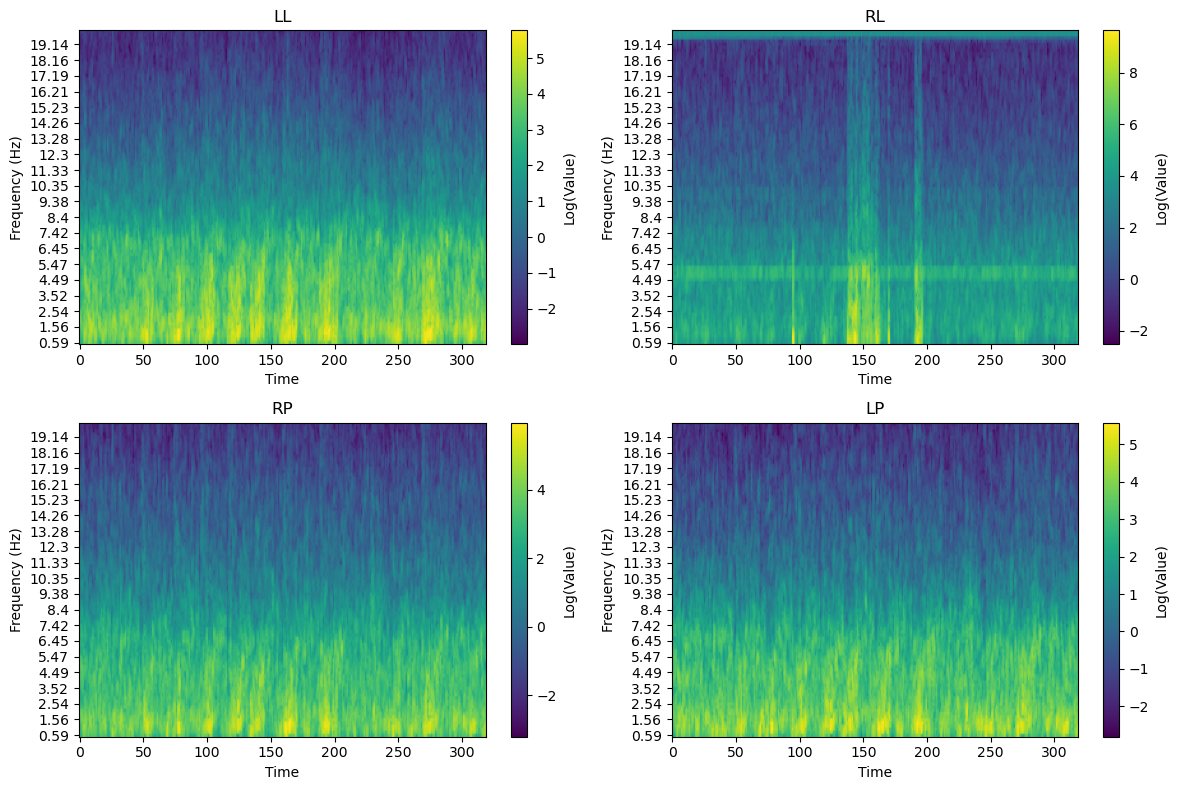

CPU times: user 1.25 s, sys: 4.74 s, total: 6 s
Wall time: 10.4 s


In [33]:
%%time

if train_mode:

    READ_SPEC_FILES = False
    READ_EEG_SPEC_FILES = False

    paths_spectograms = glob(paths.TRAIN_SPECTROGRAMS + "/*.parquet")
    print(f'There are {len(paths_spectograms)} spectrogram parquets')

    if READ_SPEC_FILES:    
        all_spectrograms = {}
        for file_path in tqdm(paths_spectograms):
            aux = pd.read_parquet(file_path)
            name = int(file_path.split("/")[-1].split('.')[0])
            all_spectrograms[name] = aux.iloc[:,1:].values
            del aux
    else:
        all_spectrograms = np.load(paths.PRE_LOADED_SPECTROGRAMS, allow_pickle=True).item()

    if config.VISUALIZE:
        idx = np.random.randint(0,len(paths_spectograms))
        spectrogram_path = paths_spectograms[idx]
        plot_spectrogram(spectrogram_path)
        
    if READ_EEG_SPEC_FILES:
        all_eegs_spec = {}
        for file_path in tqdm(paths_eegs):
            eeg_id = file_path.split("/")[-1].split(".")[0]
            eeg_spectogram = np.load(file_path)
            all_eegs[eeg_id] = eeg_spectogram
    else:
        all_eegs_spec = np.load(paths.PRE_LOADED_EEGS, allow_pickle=True).item()


X shape: torch.Size([128, 256, 8])
y shape: torch.Size([6])


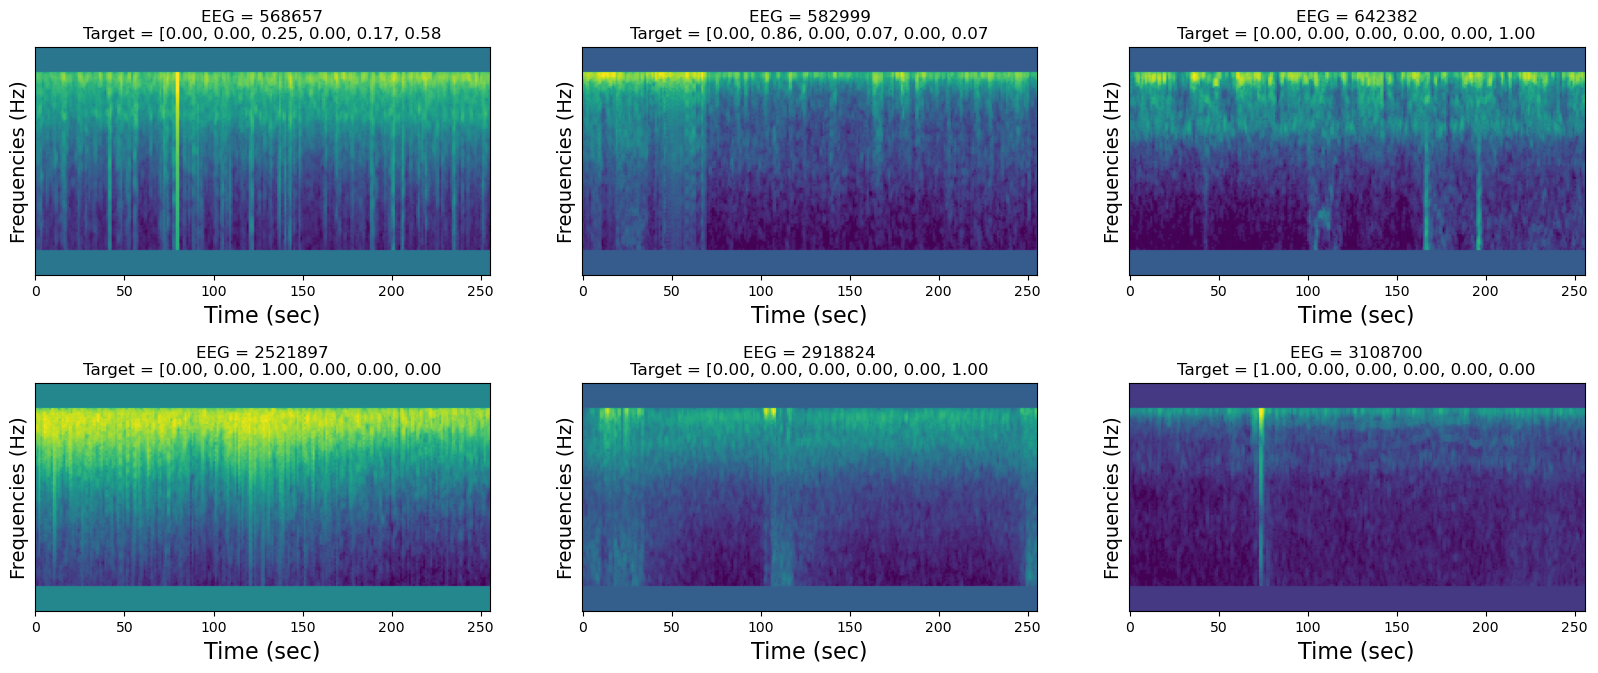

In [34]:
if train_mode:
    
    train_dataset = SpecDataset(train_df, config, all_spectrograms, all_eegs_spec, mode="train")
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS, 
        pin_memory=True, 
        drop_last=True
    )

    if config.VISUALIZE:
        X, y = train_dataset[0]
        print(f"X shape: {X.shape}")
        print(f"y shape: {y.shape}")

        ROWS = 2
        COLS = 3
        for (X, y) in train_loader:
            plt.figure(figsize=(20,8))
            for row in range(ROWS):
                for col in range(COLS):
                    plt.subplot(ROWS, COLS, row*COLS + col+1)
                    t = y[row*COLS + col]
                    img = X[row*COLS + col, :, :, 0]
                    mn = img.flatten().min()
                    mx = img.flatten().max()
                    img = (img-mn)/(mx-mn)
                    plt.imshow(img)
                    tars = f'[{t[0]:0.2f}'
                    for s in t[1:]:
                        tars += f', {s:0.2f}'
                    eeg = train_df.eeg_id.values[row*config.BATCH_SIZE + row*COLS + col]
                    plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
                    plt.yticks([])
                    plt.ylabel('Frequencies (Hz)',size=14)
                    plt.xlabel('Time (sec)',size=16)
            plt.show()
            break

In [35]:
def train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train() 
    criterion = nn.KLDivLoss(reduction="batchmean")
    scaler = torch.cuda.amp.GradScaler(enabled=config.AMP)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    
    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, (eeg_X, eeg_y, spec_X, spec_y) in enumerate(tqdm_train_loader):
            eeg_X = eeg_X.to(device)
            eeg_y = eeg_y.to(device)
            spec_X = spec_X.to(device)
            spec_y = spec_y.to(device)
            batch_size = eeg_y.size(0)
            y = eeg_y
            with torch.cuda.amp.autocast(enabled=config.AMP):
                y_preds = model(eeg_X, spec_X) 
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)

            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                global_step += 1
                scheduler.step()
            end = time.time()

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                remain = timeSince(start, float(step+1)/len(train_loader))
                lr=scheduler.get_last_lr()[0]
                info = f"Epoch: [{epoch+1}][{step}/{len(train_loader)}]"
                info += f"Elapsed {remain:s} Loss: {losses.avg:.4f} Grad: {grad_norm:.4f} LR: {lr:.8f}"
                print(info)

    return losses.avg


def valid_epoch(valid_loader, model, criterion, device):
    model.eval()
    softmax = nn.Softmax(dim=1)
    losses = AverageMeter()
    prediction_dict = {}
    preds = []
    start = end = time.time()
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, (eeg_X, eeg_y, spec_X, spec_y) in enumerate(tqdm_valid_loader):
            eeg_X = eeg_X.to(device)
            eeg_y = eeg_y.to(device)
            spec_X = spec_X.to(device)
            spec_y = spec_y.to(device)
            batch_size = eeg_y.size(0)
            y = eeg_y
            with torch.no_grad():
                y_preds = model(eeg_X, spec_X) 
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            y_preds = y_preds
            preds.append(y_preds.to('cpu').numpy())
            end = time.time()

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                remain=timeSince(start, float(step+1)/len(valid_loader))
                info = f"EVAL: [{step}/{len(valid_loader)}] Elapsed {remain:s} Loss: {losses.avg:.4f}"
                print(info)
                
    prediction_dict["predictions"] = np.concatenate(preds)
    return losses.avg, prediction_dict

In [36]:
from torch.optim.lr_scheduler import OneCycleLR

def train_loop(train_easy_df, train_hard_df, fold, all_specs, all_eegs, all_eegs_spec, model_postfix=None):
    
    LOGGER.info(f"========== Fold: {fold} training ==========")

    # ======== SPLIT ==========
    train_easy_folds = train_easy_df[train_easy_df['fold'] != fold].reset_index(drop=True)
    train_hard_folds = train_hard_df[train_hard_df['fold'] != fold].reset_index(drop=True)
    valid_folds_easy = train_easy_df[train_easy_df['fold'] == fold].reset_index(drop=True)
    valid_folds_hard = train_hard_df[train_hard_df['fold'] == fold].reset_index(drop=True)
    if not config.STAGE_2:
        # train_folds = pd.concat([train_easy_folds, train_hard_folds]).reset_index(drop=True)
        train_folds = train_easy_folds
        # valid_folds = valid_folds_easy
    else:
        train_folds = train_hard_folds
        # valid_folds = valid_folds_hard
    
    # ======== DATASETS ==========
    valid_folds = pd.concat([valid_folds_easy, valid_folds_hard])
    eeg_train_dataset = EEGDataset(
        df=train_folds,
        batch_size=CFG.batch_size,
        mode="train",
        eegs=all_eegs,
        bandpass_filter=model_block['bandpass_filter']
    )
    spec_train_dataset = SpecDataset(train_folds, config, all_specs, all_eegs_spec, mode="train", augment=True)
    train_dataset = CustomDataset(spec_train_dataset, eeg_train_dataset)
    eeg_valid_dataset = EEGDataset(
        df=valid_folds,
        batch_size=CFG.batch_size,
        mode="valid",
        eegs=all_eegs,
        bandpass_filter=model_block['bandpass_filter']
    )
    spec_valid_dataset = SpecDataset(valid_folds, config, all_specs, all_eegs_spec, mode="train", augment=False)
    valid_dataset = CustomDataset(spec_valid_dataset, eeg_valid_dataset)
    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)
    
    # ======== MODEL ==========
    eeg_model = EEGNet(
        kernels=CFG.kernels,
        in_channels=CFG.in_channels,
        fixed_kernel_size=CFG.fixed_kernel_size,
        num_classes=CFG.target_size,
        linear_layer_features=CFG.linear_layer_features,
    )
    spec_model = SpecModel(config)
    model = CombineModel(eeg_model, spec_model)
    if config.STAGE_2:
        print(f"Use model weights:", model_weights[fold])
        checkpoint = torch.load(model_weights[fold])
        model.load_state_dict(checkpoint["model"])
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=config.WEIGHT_DECAY)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-4,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

    # ======= LOSS ==========
    criterion = nn.KLDivLoss(reduction="batchmean")
    
    best_loss = np.inf
    
    if not model_postfix:
        save_model = paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_f{fold}_best.pth"
    else:
        save_model = paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_f{fold}_{model_postfix}.pth"
        
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):
        start_time = time.time()
        

        # ======= TRAIN ==========
        avg_train_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # ======= EVALUATION ==========
        # avg_val_loss_hard, prediction_dict_hard = valid_epoch(valid_loader_hard, model, criterion, device)
        # predictions_hard = prediction_dict_hard["predictions"]
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, criterion, device)
        predictions = prediction_dict["predictions"]
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save(
                {'model': model.state_dict(), 'predictions': predictions},
                save_model
            )

        
        # avg_val_loss = (avg_val_loss_hard*len(valid_loader_hard) + avg_val_loss_easy*len(valid_loader_easy)) / (len(valid_loader_easy) + len(valid_loader_hard))
        # ======= SCORING ==========
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f} time: {elapsed:.0f}s')
        

    predictions = torch.load(save_model, map_location=torch.device('cpu'))['predictions']
    valid_folds[target_preds] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

# Train stage 1

In [37]:
def get_result(oof_df):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[label_cols].values)
    preds = torch.tensor(oof_df[target_preds].values)
    preds = F.log_softmax(preds, dim=1)
    result = kl_loss(preds, labels)
    return result


In [38]:
import torch.nn.functional as F


if train_mode: 
    from sklearn.model_selection import KFold, GroupKFold
    if not config.TRAIN_FULL_DATA:

        # gkf = GroupKFold(n_splits=config.FOLDS)
        # for fold, (train_index, valid_index) in enumerate(gkf.split(train_df, train_df.target, train_df.patient_id)):
            # train_df.loc[valid_index, "fold"] = int(fold)

        gkf = GroupKFold(n_splits=config.FOLDS)
        
        # split nonoverlap easy and hard data into k-folds
        easy_split = gkf.split(train_easy, train_easy['target'], train_easy['patient_id'])
        for fold, (train_idx, valid_idx) in enumerate(easy_split):
            train_easy.loc[valid_idx, 'fold'] = fold
        
        hard_split = gkf.split(train_hard, train_hard['target'], train_hard['patient_id'])
        for fold, (train_idx, valid_idx) in enumerate(hard_split):
            train_hard.loc[valid_idx, 'fold'] = fold
        
        # split overlap easy and hard data into k-folds
        # kf = KFold(n_splits=config.FOLDS)
        # unique_eeg_id = train_easy_overlap["eeg_id"].unique()
        # train_df["fold"] = config.FOLDS
        # for fold, (train_eeg_index, valid_eeg_index) in enumerate(kf.split(unique_eeg_id)):
            # valid_eeg_id = unique_eeg_id[valid_eeg_index]
            # valid_easy_index = train_easy_overlap[train_easy_overlap.eeg_id.isin(valid_eeg_id)].index
            # train_easy_overlap.loc[valid_easy_index, "fold"] = int(fold)
            # valid_hard_index = train_hard_overlap[train_hard_overlap.eeg_id.isin(valid_eeg_id)].index
            # train_hard_overlap.loc[valid_hard_index, "fold"] = int(fold)
            
        # train_easy = pd.concat([train_easy_overlap, train_easy_nonoverlap]).reset_index(drop=True)
        # train_hard = pd.concat([train_hard_overlap, train_hard_nonoverlap]).reset_index(drop=True)

        print("Easy:")
        display(train_easy.groupby('fold').size()), sep()
        display(train_easy.head())
        print("Hard:")
        display(train_hard.groupby('fold').size()), sep()
        display(train_hard.head())

        oof_df = pd.DataFrame()
        for fold in range(config.FOLDS):
            if fold in [0, 1, 2, 3, 4]:
                _oof_df = train_loop(train_easy, train_hard, fold, all_spectrograms, all_eegs, all_eegs_spec, model_postfix="stage_1")
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== Fold {fold} result: {get_result(_oof_df)} ==========")
                print(f"========== Fold {fold} result: {get_result(_oof_df)} ==========")
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV: {get_result(oof_df)} ==========")
        oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)

Easy:


fold
0.0    2488
1.0    2488
2.0    2488
3.0    2488
4.0    2488
dtype: int64

----------------------------------------------------------------------------------------------------


,eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,entropy,total_votes,fold
0,642382,14960202,1008.0,1032.0,5955,0.0,0.0,0.0,0.0,0.0,1.0,Other,7.802343,2,3.0
1,751790,618728447,908.0,908.0,38549,0.0,0.0,1.0,0.0,0.0,0.0,GPD,7.802343,1,4.0
2,778705,52296320,0.0,0.0,40955,0.0,0.0,0.0,0.0,0.0,1.0,Other,7.686820,2,0.0
3,1629671,2036345030,0.0,160.0,37481,1.0,0.0,0.0,0.0,0.0,0.0,Seizure,7.619243,51,3.0
4,2061593,320962633,1450.0,1450.0,23828,0.0,0.0,0.0,0.0,0.0,1.0,Other,7.802343,1,4.0


Hard:


fold
0.0    1108
1.0    1107
2.0    1107
3.0    1107
4.0    1107
dtype: int64

----------------------------------------------------------------------------------------------------


,eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,entropy,total_votes,fold
0,568657,789577333,0.0,16.0,20654,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,Other,3.341757,48,3.0
1,582999,1552638400,0.0,38.0,20230,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,LPD,3.550549,154,4.0
2,1895581,128369999,1138.0,1138.0,47999,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,Other,3.565051,13,1.0
3,2482631,978166025,1902.0,1944.0,20606,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,Other,1.431066,105,2.0
4,2521897,673742515,0.0,4.0,62117,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,Other,1.516203,24,3.0


========== Fold: 0 training ==========


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [1][0/1244]Elapsed 0m 1s (remain 28m 11s) Loss: 1.6892 Grad: 129804.6953 LR: 0.00000400
Epoch: [1][50/1244]Elapsed 0m 7s (remain 2m 50s) Loss: 1.6129 Grad: 75482.1250 LR: 0.00000440
Epoch: [1][100/1244]Elapsed 0m 13s (remain 2m 27s) Loss: 1.5835 Grad: 77250.0859 LR: 0.00000556
Epoch: [1][150/1244]Elapsed 0m 18s (remain 2m 15s) Loss: 1.5419 Grad: 65232.4180 LR: 0.00000745
Epoch: [1][200/1244]Elapsed 0m 24s (remain 2m 7s) Loss: 1.5012 Grad: 40548.8438 LR: 0.00001006
Epoch: [1][250/1244]Elapsed 0m 30s (remain 1m 59s) Loss: 1.4762 Grad: 54408.9492 LR: 0.00001334
Epoch: [1][300/1244]Elapsed 0m 36s (remain 1m 53s) Loss: 1.4477 Grad: 56377.8750 LR: 0.00001723
Epoch: [1][350/1244]Elapsed 0m 41s (remain 1m 46s) Loss: 1.4226 Grad: 46463.0156 LR: 0.00002168
Epoch: [1][400/1244]Elapsed 0m 47s (remain 1m 40s) Loss: 1.4013 Grad: 58229.4883 LR: 0.00002661
Epoch: [1][450/1244]Elapsed 0m 53s (remain 1m 34s) Loss: 1.3844 Grad: 104811.7578 LR: 0.00003195
Epoch: [1][500/1244]Elapsed 0m 59s (remain 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 57s) Loss: 0.9307
EVAL: [50/450] Elapsed 0m 3s (remain 0m 31s) Loss: 1.0225
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.0337
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 1.0440
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.0445
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.0652
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.0554
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 1.0216
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.9894


Epoch 1 - Save Best Loss: 0.9692 Model
Epoch 1 - avg_train_loss: 1.1018  avg_val_loss: 0.9692 time: 180s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.9692


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [2][0/1244]Elapsed 0m 0s (remain 2m 45s) Loss: 0.4179 Grad: 298804.4375 LR: 0.00010000
Epoch: [2][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.7316 Grad: 109903.8750 LR: 0.00009999
Epoch: [2][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.7492 Grad: 47988.0312 LR: 0.00009998
Epoch: [2][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.7324 Grad: 73516.9609 LR: 0.00009995
Epoch: [2][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.7329 Grad: 79721.5078 LR: 0.00009992
Epoch: [2][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.7406 Grad: 47191.9492 LR: 0.00009988
Epoch: [2][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.7472 Grad: 63289.4844 LR: 0.00009982
Epoch: [2][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.7485 Grad: 56506.4297 LR: 0.00009976
Epoch: [2][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.7485 Grad: 71449.8984 LR: 0.00009968
Epoch: [2][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.7534 Grad: 61859.8516 LR: 0.00009960
Epoch: [2][500/1244]Elapsed 0m 59s (remain 1m

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 0.5842
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8172
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8363
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8623
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8628
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8814
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8744
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8561
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8382


Epoch 2 - Save Best Loss: 0.8291 Model


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8291


Epoch 2 - avg_train_loss: 0.6898  avg_val_loss: 0.8291 time: 182s


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [3][0/1244]Elapsed 0m 0s (remain 2m 35s) Loss: 0.1588 Grad: 173980.7969 LR: 0.00009698
Epoch: [3][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.5157 Grad: 99565.3438 LR: 0.00009673
Epoch: [3][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.5319 Grad: 106826.5469 LR: 0.00009648
Epoch: [3][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.5157 Grad: 60236.3906 LR: 0.00009621
Epoch: [3][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.5220 Grad: 77303.5234 LR: 0.00009594
Epoch: [3][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.5291 Grad: 44458.9648 LR: 0.00009566
Epoch: [3][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.5448 Grad: 62279.9766 LR: 0.00009537
Epoch: [3][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.5463 Grad: 57105.7344 LR: 0.00009507
Epoch: [3][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.5485 Grad: 84083.7344 LR: 0.00009476
Epoch: [3][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.5522 Grad: 59821.4961 LR: 0.00009445
Epoch: [3][500/1244]Elapsed 0m 59s (remain 1m

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 0.4993
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.9799
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9824
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.9992
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.0013
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.0241
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.0212
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.9887
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.9544


Epoch 3 - avg_train_loss: 0.5285  avg_val_loss: 0.9360 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.9360


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [4][0/1244]Elapsed 0m 0s (remain 2m 48s) Loss: 0.1104 Grad: 162162.1250 LR: 0.00008829
Epoch: [4][50/1244]Elapsed 0m 6s (remain 2m 20s) Loss: 0.3956 Grad: 151684.7969 LR: 0.00008783
Epoch: [4][100/1244]Elapsed 0m 11s (remain 2m 15s) Loss: 0.4254 Grad: 70341.1719 LR: 0.00008737
Epoch: [4][150/1244]Elapsed 0m 17s (remain 2m 10s) Loss: 0.4257 Grad: 113707.2031 LR: 0.00008690
Epoch: [4][200/1244]Elapsed 0m 23s (remain 2m 4s) Loss: 0.4311 Grad: 148311.5000 LR: 0.00008643
Epoch: [4][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.4381 Grad: 31477.1680 LR: 0.00008594
Epoch: [4][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.4388 Grad: 48029.8164 LR: 0.00008545
Epoch: [4][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.4448 Grad: 22732.0527 LR: 0.00008495
Epoch: [4][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.4402 Grad: 80674.8203 LR: 0.00008445
Epoch: [4][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.4451 Grad: 25767.1895 LR: 0.00008394
Epoch: [4][500/1244]Elapsed 0m 59s (remain

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 37s) Loss: 0.8943
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.9912
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9721
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.9986
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9985
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.0275
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.0263
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 1.0144
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.0039


Epoch 4 - avg_train_loss: 0.4133  avg_val_loss: 0.9997 time: 182s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.9997


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [5][0/1244]Elapsed 0m 0s (remain 2m 30s) Loss: 0.0626 Grad: 134855.5625 LR: 0.00007499
Epoch: [5][50/1244]Elapsed 0m 6s (remain 2m 22s) Loss: 0.3455 Grad: 82515.8359 LR: 0.00007438
Epoch: [5][100/1244]Elapsed 0m 12s (remain 2m 17s) Loss: 0.3405 Grad: 112219.9062 LR: 0.00007376
Epoch: [5][150/1244]Elapsed 0m 18s (remain 2m 11s) Loss: 0.3312 Grad: 74170.2578 LR: 0.00007314
Epoch: [5][200/1244]Elapsed 0m 24s (remain 2m 4s) Loss: 0.3326 Grad: 39686.0000 LR: 0.00007252
Epoch: [5][250/1244]Elapsed 0m 29s (remain 1m 58s) Loss: 0.3278 Grad: 111317.9844 LR: 0.00007189
Epoch: [5][300/1244]Elapsed 0m 35s (remain 1m 52s) Loss: 0.3295 Grad: 90388.7734 LR: 0.00007126
Epoch: [5][350/1244]Elapsed 0m 41s (remain 1m 46s) Loss: 0.3305 Grad: 22837.1250 LR: 0.00007062
Epoch: [5][400/1244]Elapsed 0m 47s (remain 1m 40s) Loss: 0.3290 Grad: 59852.3672 LR: 0.00006998
Epoch: [5][450/1244]Elapsed 0m 53s (remain 1m 34s) Loss: 0.3329 Grad: 18388.9824 LR: 0.00006933
Epoch: [5][500/1244]Elapsed 0m 59s (remain 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.9489
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0762
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.0814
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 1.0958
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.1099
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.1438
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.1316
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 1.1104
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.0901


Epoch 5 - avg_train_loss: 0.3057  avg_val_loss: 1.0804 time: 182s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.0804


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [6][0/1244]Elapsed 0m 0s (remain 2m 28s) Loss: 0.0259 Grad: 85515.0312 LR: 0.00005867
Epoch: [6][50/1244]Elapsed 0m 6s (remain 2m 20s) Loss: 0.2585 Grad: 148774.9375 LR: 0.00005798
Epoch: [6][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.2665 Grad: 33266.9570 LR: 0.00005729
Epoch: [6][150/1244]Elapsed 0m 17s (remain 2m 9s) Loss: 0.2450 Grad: 49429.5117 LR: 0.00005659
Epoch: [6][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.2489 Grad: 40825.9492 LR: 0.00005590
Epoch: [6][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.2424 Grad: 58201.2344 LR: 0.00005520
Epoch: [6][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.2412 Grad: 24594.8555 LR: 0.00005450
Epoch: [6][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.2432 Grad: 14687.8496 LR: 0.00005380
Epoch: [6][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.2430 Grad: 32014.9531 LR: 0.00005310
Epoch: [6][450/1244]Elapsed 0m 53s (remain 1m 34s) Loss: 0.2461 Grad: 24090.5410 LR: 0.00005240
Epoch: [6][500/1244]Elapsed 0m 59s (remain 1m 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 39s) Loss: 0.5098
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.1578
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.1718
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 1.1821
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.1910
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.2306
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.2162
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 1.2112
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.2018


Epoch 6 - avg_train_loss: 0.2253  avg_val_loss: 1.2025 time: 182s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.2025


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [7][0/1244]Elapsed 0m 0s (remain 2m 45s) Loss: 0.0941 Grad: 431604.1562 LR: 0.00004131
Epoch: [7][50/1244]Elapsed 0m 5s (remain 2m 20s) Loss: 0.1947 Grad: 134194.2656 LR: 0.00004062
Epoch: [7][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.1921 Grad: 34383.1562 LR: 0.00003994
Epoch: [7][150/1244]Elapsed 0m 17s (remain 2m 9s) Loss: 0.1852 Grad: 37655.8438 LR: 0.00003925
Epoch: [7][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.1855 Grad: 31572.6406 LR: 0.00003857
Epoch: [7][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.1821 Grad: 49094.0938 LR: 0.00003789
Epoch: [7][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.1847 Grad: 49959.0859 LR: 0.00003721
Epoch: [7][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.1895 Grad: 27505.0020 LR: 0.00003653
Epoch: [7][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.1894 Grad: 11620.2764 LR: 0.00003586
Epoch: [7][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.1906 Grad: 26399.1270 LR: 0.00003518
Epoch: [7][500/1244]Elapsed 0m 59s (remain 1m

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.4509
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.2162
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.2380
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 1.2418
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.2485
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.2816
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.2654
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 1.2539
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.2428


Epoch 7 - avg_train_loss: 0.1706  avg_val_loss: 1.2406 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.2406


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [8][0/1244]Elapsed 0m 0s (remain 2m 44s) Loss: 0.0764 Grad: 264587.0625 LR: 0.00002501
Epoch: [8][50/1244]Elapsed 0m 6s (remain 2m 23s) Loss: 0.1497 Grad: 72291.8359 LR: 0.00002440
Epoch: [8][100/1244]Elapsed 0m 12s (remain 2m 16s) Loss: 0.1599 Grad: 45555.4531 LR: 0.00002380
Epoch: [8][150/1244]Elapsed 0m 17s (remain 2m 10s) Loss: 0.1468 Grad: 62629.8125 LR: 0.00002321
Epoch: [8][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.1541 Grad: 30846.7031 LR: 0.00002262
Epoch: [8][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.1474 Grad: 37823.5352 LR: 0.00002203
Epoch: [8][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.1452 Grad: 34186.5938 LR: 0.00002146
Epoch: [8][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.1478 Grad: 15550.6611 LR: 0.00002088
Epoch: [8][400/1244]Elapsed 0m 47s (remain 1m 40s) Loss: 0.1488 Grad: 17819.7285 LR: 0.00002032
Epoch: [8][450/1244]Elapsed 0m 53s (remain 1m 34s) Loss: 0.1482 Grad: 16084.9463 LR: 0.00001976
Epoch: [8][500/1244]Elapsed 0m 59s (remain 1m

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.3158
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.2212
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.2407
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 1.2471
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.2683
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.2993
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.2878
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 1.2814
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.2739


Epoch 8 - avg_train_loss: 0.1354  avg_val_loss: 1.2801 time: 182s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.2801


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [9][0/1244]Elapsed 0m 0s (remain 2m 33s) Loss: 0.1048 Grad: inf LR: 0.00001172
Epoch: [9][50/1244]Elapsed 0m 6s (remain 2m 22s) Loss: 0.1415 Grad: 164719.7188 LR: 0.00001127
Epoch: [9][100/1244]Elapsed 0m 11s (remain 2m 15s) Loss: 0.1294 Grad: 80520.9766 LR: 0.00001083
Epoch: [9][150/1244]Elapsed 0m 17s (remain 2m 9s) Loss: 0.1195 Grad: 48074.2812 LR: 0.00001040
Epoch: [9][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.1233 Grad: 87489.3438 LR: 0.00000997
Epoch: [9][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.1204 Grad: 82367.7969 LR: 0.00000956
Epoch: [9][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.1182 Grad: 122678.1562 LR: 0.00000915
Epoch: [9][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.1224 Grad: 40257.4062 LR: 0.00000875
Epoch: [9][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.1220 Grad: 131032.5859 LR: 0.00000836
Epoch: [9][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.1212 Grad: 14990.1611 LR: 0.00000798
Epoch: [9][500/1244]Elapsed 0m 59s (remain 1m 27s) 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 0.2828
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.2733
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.2905
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 1.2948
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.3135
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.3465
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.3362
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 1.3253
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.3132


Epoch 9 - avg_train_loss: 0.1167  avg_val_loss: 1.3164 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.3164


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [10][0/1244]Elapsed 0m 0s (remain 2m 34s) Loss: 0.0621 Grad: 343505.7188 LR: 0.00000304
Epoch: [10][50/1244]Elapsed 0m 6s (remain 2m 24s) Loss: 0.1267 Grad: 62673.8945 LR: 0.00000281
Epoch: [10][100/1244]Elapsed 0m 12s (remain 2m 16s) Loss: 0.1197 Grad: 78495.1562 LR: 0.00000258
Epoch: [10][150/1244]Elapsed 0m 17s (remain 2m 10s) Loss: 0.1129 Grad: 174570.7969 LR: 0.00000237
Epoch: [10][200/1244]Elapsed 0m 23s (remain 2m 4s) Loss: 0.1165 Grad: 86476.3047 LR: 0.00000216
Epoch: [10][250/1244]Elapsed 0m 29s (remain 1m 58s) Loss: 0.1167 Grad: 44848.3164 LR: 0.00000196
Epoch: [10][300/1244]Elapsed 0m 35s (remain 1m 52s) Loss: 0.1159 Grad: 63775.8398 LR: 0.00000178
Epoch: [10][350/1244]Elapsed 0m 41s (remain 1m 46s) Loss: 0.1177 Grad: 36119.3398 LR: 0.00000160
Epoch: [10][400/1244]Elapsed 0m 47s (remain 1m 40s) Loss: 0.1166 Grad: 76373.8047 LR: 0.00000143
Epoch: [10][450/1244]Elapsed 0m 53s (remain 1m 34s) Loss: 0.1160 Grad: 13248.4346 LR: 0.00000127
Epoch: [10][500/1244]Elapsed 0m 59

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 42s) Loss: 0.3952
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.2826
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.2976
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 1.3045
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.3223
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.3589
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.3476
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 1.3357
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.3199


Epoch 10 - avg_train_loss: 0.1084  avg_val_loss: 1.3208 time: 182s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.3208


========== Fold 0 result: 0.8290856996639322 ==========
========== Fold: 1 training ==========


========== Fold 0 result: 0.8290856996639322 ==========


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [1][0/1244]Elapsed 0m 0s (remain 2m 39s) Loss: 1.7768 Grad: 141747.5469 LR: 0.00000400
Epoch: [1][50/1244]Elapsed 0m 6s (remain 2m 20s) Loss: 1.6186 Grad: 135221.1875 LR: 0.00000440
Epoch: [1][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 1.5786 Grad: 46257.2148 LR: 0.00000556
Epoch: [1][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 1.5399 Grad: 38917.8438 LR: 0.00000745
Epoch: [1][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 1.4930 Grad: 62155.2969 LR: 0.00001006
Epoch: [1][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 1.4551 Grad: 27157.5273 LR: 0.00001334
Epoch: [1][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 1.4306 Grad: 21121.2168 LR: 0.00001723
Epoch: [1][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 1.4074 Grad: 23777.1543 LR: 0.00002168
Epoch: [1][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 1.3832 Grad: 31737.5371 LR: 0.00002661
Epoch: [1][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 1.3573 Grad: 50526.1562 LR: 0.00003195
Epoch: [1][500/1244]Elapsed 0m 59s (remain 1m

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.0601
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0884
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.0764
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 1.1082
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.1293
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.1184
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.1470
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 1.1075
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.0792


Epoch 1 - Save Best Loss: 1.0474 Model
Epoch 1 - avg_train_loss: 1.0669  avg_val_loss: 1.0474 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.0474


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [2][0/1244]Elapsed 0m 0s (remain 2m 26s) Loss: 0.4868 Grad: nan LR: 0.00010000
Epoch: [2][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.7327 Grad: 40893.5312 LR: 0.00009999
Epoch: [2][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.7576 Grad: 39500.0547 LR: 0.00009998
Epoch: [2][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.7432 Grad: 52184.6328 LR: 0.00009995
Epoch: [2][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.7433 Grad: 22716.7012 LR: 0.00009992
Epoch: [2][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.7467 Grad: 65409.1172 LR: 0.00009988
Epoch: [2][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.7496 Grad: 100367.7109 LR: 0.00009982
Epoch: [2][350/1244]Elapsed 0m 41s (remain 1m 44s) Loss: 0.7416 Grad: 55909.8555 LR: 0.00009976
Epoch: [2][400/1244]Elapsed 0m 47s (remain 1m 38s) Loss: 0.7441 Grad: 59969.6445 LR: 0.00009968
Epoch: [2][450/1244]Elapsed 0m 52s (remain 1m 33s) Loss: 0.7401 Grad: 74380.5625 LR: 0.00009960
Epoch: [2][500/1244]Elapsed 0m 58s (remain 1m 27s) Lo

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 1.2607
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0813
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.0520
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 1.0561
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.0678
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.0506
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.0857
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 1.0479
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.0198


Epoch 2 - Save Best Loss: 0.9930 Model
Epoch 2 - avg_train_loss: 0.6845  avg_val_loss: 0.9930 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.9930


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [3][0/1244]Elapsed 0m 0s (remain 2m 54s) Loss: 0.3740 Grad: 292981.9062 LR: 0.00009698
Epoch: [3][50/1244]Elapsed 0m 6s (remain 2m 21s) Loss: 0.5447 Grad: 106253.9922 LR: 0.00009673
Epoch: [3][100/1244]Elapsed 0m 12s (remain 2m 16s) Loss: 0.5784 Grad: 69631.1094 LR: 0.00009648
Epoch: [3][150/1244]Elapsed 0m 18s (remain 2m 10s) Loss: 0.5572 Grad: 105953.4375 LR: 0.00009621
Epoch: [3][200/1244]Elapsed 0m 23s (remain 2m 4s) Loss: 0.5555 Grad: 25151.8398 LR: 0.00009594
Epoch: [3][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.5645 Grad: 107449.9297 LR: 0.00009566
Epoch: [3][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.5704 Grad: 128598.0547 LR: 0.00009537
Epoch: [3][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.5681 Grad: 107269.8125 LR: 0.00009507
Epoch: [3][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.5682 Grad: 164044.8281 LR: 0.00009476
Epoch: [3][450/1244]Elapsed 0m 53s (remain 1m 34s) Loss: 0.5676 Grad: 84118.0234 LR: 0.00009445
Epoch: [3][500/1244]Elapsed 0m 59s (rem

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.3803
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0191
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9882
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.9995
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.0223
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.0025
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.0395
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 1.0022
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.9791


Epoch 3 - Save Best Loss: 0.9573 Model
Epoch 3 - avg_train_loss: 0.5309  avg_val_loss: 0.9573 time: 182s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.9573


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [4][0/1244]Elapsed 0m 0s (remain 2m 30s) Loss: 0.2401 Grad: 209437.1562 LR: 0.00008829
Epoch: [4][50/1244]Elapsed 0m 6s (remain 2m 21s) Loss: 0.4176 Grad: 49587.4531 LR: 0.00008783
Epoch: [4][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.4559 Grad: 35993.3164 LR: 0.00008737
Epoch: [4][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.4486 Grad: 61461.3633 LR: 0.00008690
Epoch: [4][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.4440 Grad: 13793.6387 LR: 0.00008643
Epoch: [4][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.4525 Grad: 69784.8125 LR: 0.00008594
Epoch: [4][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.4541 Grad: 41225.9727 LR: 0.00008545
Epoch: [4][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.4504 Grad: 47712.5078 LR: 0.00008495
Epoch: [4][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.4484 Grad: 82630.9844 LR: 0.00008445
Epoch: [4][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.4474 Grad: 46693.2734 LR: 0.00008394
Epoch: [4][500/1244]Elapsed 0m 59s (remain 1m 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 37s) Loss: 1.5784
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0096
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9915
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 1.0089
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.0257
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.0063
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.0339
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 1.0008
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.9845


Epoch 4 - avg_train_loss: 0.4131  avg_val_loss: 0.9723 time: 182s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.9723


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [5][0/1244]Elapsed 0m 0s (remain 2m 29s) Loss: 0.1559 Grad: 242113.8594 LR: 0.00007499
Epoch: [5][50/1244]Elapsed 0m 6s (remain 2m 21s) Loss: 0.3380 Grad: 43146.9414 LR: 0.00007438
Epoch: [5][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.3492 Grad: 38066.4297 LR: 0.00007376
Epoch: [5][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.3453 Grad: 35519.1953 LR: 0.00007314
Epoch: [5][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.3491 Grad: 11285.8457 LR: 0.00007252
Epoch: [5][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.3535 Grad: 108960.8984 LR: 0.00007189
Epoch: [5][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.3566 Grad: 43090.2109 LR: 0.00007126
Epoch: [5][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.3558 Grad: 47763.1445 LR: 0.00007062
Epoch: [5][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.3515 Grad: 76011.5859 LR: 0.00006998
Epoch: [5][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.3516 Grad: 51920.7656 LR: 0.00006933
Epoch: [5][500/1244]Elapsed 0m 59s (remain 1m

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 39s) Loss: 1.8458
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.1258
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.1036
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 1.1410
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.1370
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.1168
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.1496
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 1.1224
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.1127


Epoch 5 - avg_train_loss: 0.3192  avg_val_loss: 1.1051 time: 182s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.1051


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [6][0/1244]Elapsed 0m 0s (remain 2m 35s) Loss: 0.1309 Grad: 287361.8750 LR: 0.00005867
Epoch: [6][50/1244]Elapsed 0m 6s (remain 2m 22s) Loss: 0.2777 Grad: 103878.6250 LR: 0.00005798
Epoch: [6][100/1244]Elapsed 0m 12s (remain 2m 16s) Loss: 0.2965 Grad: 42377.7539 LR: 0.00005729
Epoch: [6][150/1244]Elapsed 0m 17s (remain 2m 10s) Loss: 0.2867 Grad: 54700.9609 LR: 0.00005659
Epoch: [6][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.2780 Grad: 17898.4434 LR: 0.00005590
Epoch: [6][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.2756 Grad: 39164.2773 LR: 0.00005520
Epoch: [6][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.2747 Grad: 18395.0371 LR: 0.00005450
Epoch: [6][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.2731 Grad: 57162.7070 LR: 0.00005380
Epoch: [6][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.2709 Grad: 101451.2266 LR: 0.00005310
Epoch: [6][450/1244]Elapsed 0m 53s (remain 1m 34s) Loss: 0.2704 Grad: 74421.0859 LR: 0.00005240
Epoch: [6][500/1244]Elapsed 0m 59s (remain 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 40s) Loss: 1.5301
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0599
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.0656
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 1.0746
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.0703
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.0575
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.0934
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 1.0833
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.0926


Epoch 6 - avg_train_loss: 0.2407  avg_val_loss: 1.1061 time: 182s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.1061


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [7][0/1244]Elapsed 0m 0s (remain 2m 44s) Loss: 0.0413 Grad: 96213.2031 LR: 0.00004131
Epoch: [7][50/1244]Elapsed 0m 6s (remain 2m 20s) Loss: 0.2354 Grad: 36083.2461 LR: 0.00004062
Epoch: [7][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.2195 Grad: 49710.3867 LR: 0.00003994
Epoch: [7][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.2087 Grad: 17496.9219 LR: 0.00003925
Epoch: [7][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.2094 Grad: 7515.7363 LR: 0.00003857
Epoch: [7][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.2086 Grad: 18373.5742 LR: 0.00003789
Epoch: [7][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.2056 Grad: 23675.1230 LR: 0.00003721
Epoch: [7][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.2049 Grad: 33119.4531 LR: 0.00003653
Epoch: [7][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.2028 Grad: 29875.0117 LR: 0.00003586
Epoch: [7][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.2027 Grad: 23173.0527 LR: 0.00003518
Epoch: [7][500/1244]Elapsed 0m 59s (remain 1m 27

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.4688
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.1092
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.1236
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 1.1817
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.1633
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.1362
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.1721
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 1.1693
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.1897


Epoch 7 - avg_train_loss: 0.1818  avg_val_loss: 1.2075 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.2075


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [8][0/1244]Elapsed 0m 0s (remain 2m 28s) Loss: 0.0336 Grad: 101841.4141 LR: 0.00002501
Epoch: [8][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.1797 Grad: 65941.3828 LR: 0.00002440
Epoch: [8][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.1743 Grad: 93251.7891 LR: 0.00002380
Epoch: [8][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.1620 Grad: 47405.0273 LR: 0.00002321
Epoch: [8][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.1589 Grad: 108508.8281 LR: 0.00002262
Epoch: [8][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.1580 Grad: 159261.3750 LR: 0.00002203
Epoch: [8][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.1588 Grad: 78265.9453 LR: 0.00002146
Epoch: [8][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.1602 Grad: 45890.1133 LR: 0.00002088
Epoch: [8][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.1622 Grad: 83421.3125 LR: 0.00002032
Epoch: [8][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.1631 Grad: 62663.4609 LR: 0.00001976
Epoch: [8][500/1244]Elapsed 0m 58s (remain 1

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 1.6958
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0964
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.1165
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 1.1675
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.1431
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.1171
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.1539
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 1.1506
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.1715


Epoch 8 - avg_train_loss: 0.1468  avg_val_loss: 1.1912 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.1912


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [9][0/1244]Elapsed 0m 0s (remain 2m 35s) Loss: 0.0492 Grad: 197827.7812 LR: 0.00001172
Epoch: [9][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.1749 Grad: 58692.8477 LR: 0.00001127
Epoch: [9][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.1549 Grad: 59114.6445 LR: 0.00001083
Epoch: [9][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.1425 Grad: 36620.3984 LR: 0.00001040
Epoch: [9][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.1450 Grad: 17808.2871 LR: 0.00000997
Epoch: [9][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.1430 Grad: 47326.1445 LR: 0.00000956
Epoch: [9][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.1411 Grad: 22047.0742 LR: 0.00000915
Epoch: [9][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.1426 Grad: 73233.2500 LR: 0.00000875
Epoch: [9][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.1411 Grad: 116393.0859 LR: 0.00000836
Epoch: [9][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.1409 Grad: 73615.7578 LR: 0.00000798
Epoch: [9][500/1244]Elapsed 0m 59s (remain 1m

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 37s) Loss: 1.5655
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.1262
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.1218
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 1.1607
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.1465
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.1161
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.1532
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 1.1492
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.1657


Epoch 9 - avg_train_loss: 0.1245  avg_val_loss: 1.1816 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.1816


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [10][0/1244]Elapsed 0m 0s (remain 2m 29s) Loss: 0.0669 Grad: 232840.5625 LR: 0.00000304
Epoch: [10][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.1564 Grad: 51907.0000 LR: 0.00000281
Epoch: [10][100/1244]Elapsed 0m 11s (remain 2m 13s) Loss: 0.1401 Grad: 22457.1465 LR: 0.00000258
Epoch: [10][150/1244]Elapsed 0m 17s (remain 2m 9s) Loss: 0.1336 Grad: 52316.0664 LR: 0.00000237
Epoch: [10][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.1325 Grad: 14229.0791 LR: 0.00000216
Epoch: [10][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.1290 Grad: 43563.5859 LR: 0.00000196
Epoch: [10][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.1274 Grad: 9964.4307 LR: 0.00000178
Epoch: [10][350/1244]Elapsed 0m 41s (remain 1m 46s) Loss: 0.1265 Grad: 25614.9609 LR: 0.00000160
Epoch: [10][400/1244]Elapsed 0m 47s (remain 1m 40s) Loss: 0.1256 Grad: 65798.4219 LR: 0.00000143
Epoch: [10][450/1244]Elapsed 0m 53s (remain 1m 34s) Loss: 0.1250 Grad: 41919.1172 LR: 0.00000127
Epoch: [10][500/1244]Elapsed 0m 59s (

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.5491
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.1194
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.1159
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 1.1611
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.1477
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.1189
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.1542
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 1.1519
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.1687


Epoch 10 - avg_train_loss: 0.1140  avg_val_loss: 1.1871 time: 183s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.1871


========== Fold 1 result: 0.9572717165637898 ==========
========== Fold: 2 training ==========


========== Fold 1 result: 0.9572717165637898 ==========


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [1][0/1244]Elapsed 0m 0s (remain 2m 51s) Loss: 1.7176 Grad: 165831.0000 LR: 0.00000400
Epoch: [1][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 1.6328 Grad: 184401.3594 LR: 0.00000440
Epoch: [1][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 1.6030 Grad: 129745.4219 LR: 0.00000556
Epoch: [1][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 1.5614 Grad: 76424.9297 LR: 0.00000745
Epoch: [1][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 1.5191 Grad: 106159.0391 LR: 0.00001006
Epoch: [1][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 1.4842 Grad: 34893.1367 LR: 0.00001334
Epoch: [1][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 1.4595 Grad: 94357.1562 LR: 0.00001723
Epoch: [1][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 1.4396 Grad: 41958.7305 LR: 0.00002168
Epoch: [1][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 1.4176 Grad: 50010.7617 LR: 0.00002661
Epoch: [1][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 1.3955 Grad: 38481.1211 LR: 0.00003195
Epoch: [1][500/1244]Elapsed 0m 58s (remain 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.4824
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7980
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8185
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8118
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7970
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7995
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8110
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8030
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7899


Epoch 1 - Save Best Loss: 0.7771 Model
Epoch 1 - avg_train_loss: 1.1031  avg_val_loss: 0.7771 time: 180s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7771


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [2][0/1244]Elapsed 0m 0s (remain 2m 20s) Loss: 0.3873 Grad: nan LR: 0.00010000
Epoch: [2][50/1244]Elapsed 0m 5s (remain 2m 18s) Loss: 0.7061 Grad: 160816.5000 LR: 0.00009999
Epoch: [2][100/1244]Elapsed 0m 11s (remain 2m 13s) Loss: 0.7463 Grad: 184295.6719 LR: 0.00009998
Epoch: [2][150/1244]Elapsed 0m 17s (remain 2m 9s) Loss: 0.7297 Grad: 93715.4922 LR: 0.00009995
Epoch: [2][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.7410 Grad: 83390.1484 LR: 0.00009992
Epoch: [2][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.7324 Grad: 58126.4258 LR: 0.00009988
Epoch: [2][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.7420 Grad: 58371.8438 LR: 0.00009982
Epoch: [2][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.7374 Grad: 42659.6289 LR: 0.00009976
Epoch: [2][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.7365 Grad: 61199.7500 LR: 0.00009968
Epoch: [2][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.7392 Grad: 46097.7734 LR: 0.00009960
Epoch: [2][500/1244]Elapsed 0m 58s (remain 1m 27s) L

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 0.8008
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6859
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7327
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7206
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7194
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7290
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7375
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7360
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7292


Epoch 2 - Save Best Loss: 0.7228 Model
Epoch 2 - avg_train_loss: 0.6888  avg_val_loss: 0.7228 time: 180s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7228


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [3][0/1244]Elapsed 0m 0s (remain 2m 43s) Loss: 0.1507 Grad: 140495.5625 LR: 0.00009698
Epoch: [3][50/1244]Elapsed 0m 6s (remain 2m 20s) Loss: 0.5014 Grad: 55203.2266 LR: 0.00009673
Epoch: [3][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.5370 Grad: 112231.1797 LR: 0.00009648
Epoch: [3][150/1244]Elapsed 0m 17s (remain 2m 9s) Loss: 0.5380 Grad: 78453.8359 LR: 0.00009621
Epoch: [3][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.5492 Grad: 118787.5625 LR: 0.00009594
Epoch: [3][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.5489 Grad: 73105.1406 LR: 0.00009566
Epoch: [3][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.5653 Grad: 43937.5781 LR: 0.00009537
Epoch: [3][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.5610 Grad: 55272.2188 LR: 0.00009507
Epoch: [3][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.5547 Grad: 62569.0820 LR: 0.00009476
Epoch: [3][450/1244]Elapsed 0m 52s (remain 1m 33s) Loss: 0.5559 Grad: 40541.9883 LR: 0.00009445
Epoch: [3][500/1244]Elapsed 0m 58s (remain 1

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.7731
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6292
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7057
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7027
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7144
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7278
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7432
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7502
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7559


Epoch 3 - avg_train_loss: 0.5277  avg_val_loss: 0.7541 time: 180s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7541


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [4][0/1244]Elapsed 0m 0s (remain 2m 35s) Loss: 0.1220 Grad: 159485.4688 LR: 0.00008829
Epoch: [4][50/1244]Elapsed 0m 5s (remain 2m 18s) Loss: 0.3940 Grad: 82453.1562 LR: 0.00008783
Epoch: [4][100/1244]Elapsed 0m 11s (remain 2m 12s) Loss: 0.4352 Grad: 100449.0781 LR: 0.00008737
Epoch: [4][150/1244]Elapsed 0m 17s (remain 2m 7s) Loss: 0.4261 Grad: 85124.1641 LR: 0.00008690
Epoch: [4][200/1244]Elapsed 0m 23s (remain 2m 1s) Loss: 0.4285 Grad: 85433.5234 LR: 0.00008643
Epoch: [4][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.4335 Grad: 49948.2500 LR: 0.00008594
Epoch: [4][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.4505 Grad: 33770.3281 LR: 0.00008545
Epoch: [4][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.4438 Grad: 71169.2344 LR: 0.00008495
Epoch: [4][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.4384 Grad: 69817.7812 LR: 0.00008445
Epoch: [4][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.4383 Grad: 38469.6406 LR: 0.00008394
Epoch: [4][500/1244]Elapsed 0m 59s (remain 1m

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.7723
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7183
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7933
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7754
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7865
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7940
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8070
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8234
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8369


Epoch 4 - avg_train_loss: 0.4145  avg_val_loss: 0.8368 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8368


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [5][0/1244]Elapsed 0m 0s (remain 2m 43s) Loss: 0.0854 Grad: 242890.9219 LR: 0.00007499
Epoch: [5][50/1244]Elapsed 0m 6s (remain 2m 21s) Loss: 0.3186 Grad: 41827.2383 LR: 0.00007438
Epoch: [5][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.3359 Grad: 136706.5156 LR: 0.00007376
Epoch: [5][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.3274 Grad: 43089.4922 LR: 0.00007314
Epoch: [5][200/1244]Elapsed 0m 23s (remain 2m 1s) Loss: 0.3417 Grad: 98276.6875 LR: 0.00007252
Epoch: [5][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.3429 Grad: 134373.8594 LR: 0.00007189
Epoch: [5][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.3525 Grad: 63716.8086 LR: 0.00007126
Epoch: [5][350/1244]Elapsed 0m 41s (remain 1m 44s) Loss: 0.3439 Grad: 70823.8750 LR: 0.00007062
Epoch: [5][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.3379 Grad: 26060.9805 LR: 0.00006998
Epoch: [5][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.3337 Grad: 12704.6504 LR: 0.00006933
Epoch: [5][500/1244]Elapsed 0m 58s (remain 1

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 0.8300
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8101
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8989
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8695
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8645
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8801
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8927
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.9099
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.9224


Epoch 5 - avg_train_loss: 0.3092  avg_val_loss: 0.9271 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.9271


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [6][0/1244]Elapsed 0m 0s (remain 2m 28s) Loss: 0.1151 Grad: 314962.5625 LR: 0.00005867
Epoch: [6][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.2546 Grad: 31769.8438 LR: 0.00005798
Epoch: [6][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.2468 Grad: 92280.8281 LR: 0.00005729
Epoch: [6][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.2431 Grad: 53474.4648 LR: 0.00005659
Epoch: [6][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.2505 Grad: 99182.0859 LR: 0.00005590
Epoch: [6][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.2482 Grad: 60017.9297 LR: 0.00005520
Epoch: [6][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.2522 Grad: 31103.0234 LR: 0.00005450
Epoch: [6][350/1244]Elapsed 0m 41s (remain 1m 44s) Loss: 0.2498 Grad: 41083.8672 LR: 0.00005380
Epoch: [6][400/1244]Elapsed 0m 47s (remain 1m 38s) Loss: 0.2456 Grad: 89826.5703 LR: 0.00005310
Epoch: [6][450/1244]Elapsed 0m 52s (remain 1m 32s) Loss: 0.2433 Grad: 88714.2734 LR: 0.00005240
Epoch: [6][500/1244]Elapsed 0m 58s (remain 1m 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 0.8801
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8618
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9229
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.9113
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8999
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9143
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9227
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.9480
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.9666


Epoch 6 - avg_train_loss: 0.2319  avg_val_loss: 0.9806 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.9806


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [7][0/1244]Elapsed 0m 0s (remain 2m 27s) Loss: 0.0527 Grad: 260022.5938 LR: 0.00004131
Epoch: [7][50/1244]Elapsed 0m 5s (remain 2m 18s) Loss: 0.2070 Grad: 31016.7090 LR: 0.00004062
Epoch: [7][100/1244]Elapsed 0m 11s (remain 2m 12s) Loss: 0.2029 Grad: 120248.6562 LR: 0.00003994
Epoch: [7][150/1244]Elapsed 0m 17s (remain 2m 6s) Loss: 0.1864 Grad: 31490.7148 LR: 0.00003925
Epoch: [7][200/1244]Elapsed 0m 23s (remain 2m 1s) Loss: 0.1980 Grad: 123949.4531 LR: 0.00003857
Epoch: [7][250/1244]Elapsed 0m 29s (remain 1m 55s) Loss: 0.1996 Grad: 45904.7539 LR: 0.00003789
Epoch: [7][300/1244]Elapsed 0m 35s (remain 1m 49s) Loss: 0.1993 Grad: 122867.4844 LR: 0.00003721
Epoch: [7][350/1244]Elapsed 0m 40s (remain 1m 44s) Loss: 0.1968 Grad: 91159.5391 LR: 0.00003653
Epoch: [7][400/1244]Elapsed 0m 46s (remain 1m 38s) Loss: 0.1907 Grad: 100624.3438 LR: 0.00003586
Epoch: [7][450/1244]Elapsed 0m 52s (remain 1m 32s) Loss: 0.1886 Grad: 25800.4121 LR: 0.00003518
Epoch: [7][500/1244]Elapsed 0m 58s (remain

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.0621
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8933
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9905
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.9742
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9605
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9777
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9869
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 1.0129
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.0305


Epoch 7 - avg_train_loss: 0.1766  avg_val_loss: 1.0363 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.0363


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [8][0/1244]Elapsed 0m 0s (remain 2m 31s) Loss: 0.0392 Grad: 137533.7969 LR: 0.00002501
Epoch: [8][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.1401 Grad: 49210.1836 LR: 0.00002440
Epoch: [8][100/1244]Elapsed 0m 11s (remain 2m 13s) Loss: 0.1386 Grad: 57813.5703 LR: 0.00002380
Epoch: [8][150/1244]Elapsed 0m 17s (remain 2m 7s) Loss: 0.1353 Grad: 17951.5449 LR: 0.00002321
Epoch: [8][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.1464 Grad: 98420.2656 LR: 0.00002262
Epoch: [8][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.1514 Grad: 47691.9766 LR: 0.00002203
Epoch: [8][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.1497 Grad: 26639.2676 LR: 0.00002146
Epoch: [8][350/1244]Elapsed 0m 41s (remain 1m 44s) Loss: 0.1472 Grad: 15252.0449 LR: 0.00002088
Epoch: [8][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.1450 Grad: 34952.3438 LR: 0.00002032
Epoch: [8][450/1244]Elapsed 0m 52s (remain 1m 33s) Loss: 0.1439 Grad: 36305.3594 LR: 0.00001976
Epoch: [8][500/1244]Elapsed 0m 58s (remain 1m 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.1178
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.9307
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.0165
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.9933
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9839
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.0019
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.0075
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 1.0367
EVAL: [400/450] Elapsed 0m 31s (remain 0m 3s) Loss: 1.0569


Epoch 8 - avg_train_loss: 0.1396  avg_val_loss: 1.0681 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.0681


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [9][0/1244]Elapsed 0m 0s (remain 2m 20s) Loss: 0.1028 Grad: nan LR: 0.00001172
Epoch: [9][50/1244]Elapsed 0m 5s (remain 2m 18s) Loss: 0.1296 Grad: 25816.2422 LR: 0.00001127
Epoch: [9][100/1244]Elapsed 0m 11s (remain 2m 13s) Loss: 0.1248 Grad: 61813.1562 LR: 0.00001083
Epoch: [9][150/1244]Elapsed 0m 17s (remain 2m 7s) Loss: 0.1219 Grad: 30945.7324 LR: 0.00001040
Epoch: [9][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.1247 Grad: 75345.6250 LR: 0.00000997
Epoch: [9][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.1257 Grad: 31976.9766 LR: 0.00000956
Epoch: [9][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.1269 Grad: 22592.4258 LR: 0.00000915
Epoch: [9][350/1244]Elapsed 0m 41s (remain 1m 44s) Loss: 0.1258 Grad: 65189.5742 LR: 0.00000875
Epoch: [9][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.1228 Grad: 38513.2852 LR: 0.00000836
Epoch: [9][450/1244]Elapsed 0m 52s (remain 1m 33s) Loss: 0.1233 Grad: 14011.8438 LR: 0.00000798
Epoch: [9][500/1244]Elapsed 0m 58s (remain 1m 27s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 40s) Loss: 1.1916
EVAL: [50/450] Elapsed 0m 3s (remain 0m 31s) Loss: 0.9370
EVAL: [100/450] Elapsed 0m 7s (remain 0m 27s) Loss: 1.0133
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.9891
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9781
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9936
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9979
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 1.0402
EVAL: [400/450] Elapsed 0m 31s (remain 0m 3s) Loss: 1.0660


Epoch 9 - avg_train_loss: 0.1209  avg_val_loss: 1.0852 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.0852


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [10][0/1244]Elapsed 0m 0s (remain 2m 45s) Loss: 0.0326 Grad: 188671.5469 LR: 0.00000304
Epoch: [10][50/1244]Elapsed 0m 6s (remain 2m 20s) Loss: 0.1082 Grad: 26135.1523 LR: 0.00000281
Epoch: [10][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.1055 Grad: 43161.0898 LR: 0.00000258
Epoch: [10][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.1058 Grad: 15773.9385 LR: 0.00000237
Epoch: [10][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.1086 Grad: 73219.1719 LR: 0.00000216
Epoch: [10][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.1129 Grad: 80840.3203 LR: 0.00000196
Epoch: [10][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.1128 Grad: 11769.5264 LR: 0.00000178
Epoch: [10][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.1109 Grad: 55727.0781 LR: 0.00000160
Epoch: [10][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.1085 Grad: 39489.1133 LR: 0.00000143
Epoch: [10][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.1089 Grad: 26584.7695 LR: 0.00000127
Epoch: [10][500/1244]Elapsed 0m 58s 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.2514
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.9237
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.0106
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.9835
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9719
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9910
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9989
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 1.0345
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.0564


Epoch 10 - avg_train_loss: 0.1118  avg_val_loss: 1.0719 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.0719


========== Fold 2 result: 0.7228193608062368 ==========
========== Fold: 3 training ==========


========== Fold 2 result: 0.7228193608062368 ==========


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [1][0/1244]Elapsed 0m 0s (remain 2m 38s) Loss: 1.7162 Grad: 156012.0938 LR: 0.00000400
Epoch: [1][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 1.6383 Grad: 76810.7422 LR: 0.00000440
Epoch: [1][100/1244]Elapsed 0m 11s (remain 2m 13s) Loss: 1.6005 Grad: 49263.1836 LR: 0.00000556
Epoch: [1][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 1.5617 Grad: 44968.8086 LR: 0.00000745
Epoch: [1][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 1.5263 Grad: 85278.5781 LR: 0.00001006
Epoch: [1][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 1.4952 Grad: 68053.7734 LR: 0.00001334
Epoch: [1][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 1.4748 Grad: 39009.6758 LR: 0.00001723
Epoch: [1][350/1244]Elapsed 0m 41s (remain 1m 44s) Loss: 1.4542 Grad: 77258.9219 LR: 0.00002168
Epoch: [1][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 1.4328 Grad: 43879.9102 LR: 0.00002661
Epoch: [1][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 1.4114 Grad: 37615.0664 LR: 0.00003195
Epoch: [1][500/1244]Elapsed 0m 58s (remain 1m 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 40s) Loss: 0.7379
EVAL: [50/450] Elapsed 0m 3s (remain 0m 31s) Loss: 0.8145
EVAL: [100/450] Elapsed 0m 7s (remain 0m 27s) Loss: 0.8464
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8515
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8639
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8647
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8618
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.8403
EVAL: [400/450] Elapsed 0m 31s (remain 0m 3s) Loss: 0.8138


Epoch 1 - Save Best Loss: 0.7985 Model
Epoch 1 - avg_train_loss: 1.0986  avg_val_loss: 0.7985 time: 182s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7985


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [2][0/1244]Elapsed 0m 0s (remain 2m 32s) Loss: 0.3156 Grad: 222346.1719 LR: 0.00010000
Epoch: [2][50/1244]Elapsed 0m 5s (remain 2m 20s) Loss: 0.6771 Grad: 145433.8438 LR: 0.00009999
Epoch: [2][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.7276 Grad: 124255.8594 LR: 0.00009998
Epoch: [2][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.7431 Grad: 56187.8984 LR: 0.00009995
Epoch: [2][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.7438 Grad: 51725.2422 LR: 0.00009992
Epoch: [2][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.7561 Grad: 39931.3438 LR: 0.00009988
Epoch: [2][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.7668 Grad: 68727.8359 LR: 0.00009982
Epoch: [2][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.7596 Grad: 98667.6016 LR: 0.00009976
Epoch: [2][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.7591 Grad: 66745.2266 LR: 0.00009968
Epoch: [2][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.7564 Grad: 35452.0859 LR: 0.00009960
Epoch: [2][500/1244]Elapsed 0m 59s (remain 1

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 37s) Loss: 0.6573
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7602
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7958
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.7943
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7965
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8005
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7992
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.7835
EVAL: [400/450] Elapsed 0m 31s (remain 0m 3s) Loss: 0.7651


Epoch 2 - Save Best Loss: 0.7585 Model
Epoch 2 - avg_train_loss: 0.6930  avg_val_loss: 0.7585 time: 182s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7585


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [3][0/1244]Elapsed 0m 0s (remain 2m 29s) Loss: 0.4355 Grad: 329235.7188 LR: 0.00009698
Epoch: [3][50/1244]Elapsed 0m 6s (remain 2m 20s) Loss: 0.4909 Grad: 161676.9531 LR: 0.00009673
Epoch: [3][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.5521 Grad: 183637.6875 LR: 0.00009648
Epoch: [3][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.5445 Grad: 114258.8750 LR: 0.00009621
Epoch: [3][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.5418 Grad: 130174.8984 LR: 0.00009594
Epoch: [3][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.5595 Grad: 120242.0000 LR: 0.00009566
Epoch: [3][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.5700 Grad: 187978.3125 LR: 0.00009537
Epoch: [3][350/1244]Elapsed 0m 41s (remain 1m 44s) Loss: 0.5671 Grad: 198253.4844 LR: 0.00009507
Epoch: [3][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.5722 Grad: 120397.1641 LR: 0.00009476
Epoch: [3][450/1244]Elapsed 0m 52s (remain 1m 33s) Loss: 0.5715 Grad: 88854.9922 LR: 0.00009445
Epoch: [3][500/1244]Elapsed 0m 58s (re

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 0.5176
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8102
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8341
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8180
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8135
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8261
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8286
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.8226
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8124


Epoch 3 - avg_train_loss: 0.5414  avg_val_loss: 0.8144 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8144


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [4][0/1244]Elapsed 0m 0s (remain 2m 32s) Loss: 0.1193 Grad: 218205.1094 LR: 0.00008829
Epoch: [4][50/1244]Elapsed 0m 5s (remain 2m 20s) Loss: 0.3844 Grad: 151546.1562 LR: 0.00008783
Epoch: [4][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.4363 Grad: 143722.9531 LR: 0.00008737
Epoch: [4][150/1244]Elapsed 0m 17s (remain 2m 9s) Loss: 0.4232 Grad: 70217.0625 LR: 0.00008690
Epoch: [4][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.4162 Grad: nan LR: 0.00008643
Epoch: [4][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.4262 Grad: 63333.0078 LR: 0.00008594
Epoch: [4][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.4346 Grad: 93779.5000 LR: 0.00008545
Epoch: [4][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.4322 Grad: 89547.1797 LR: 0.00008495
Epoch: [4][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.4363 Grad: 76190.6172 LR: 0.00008445
Epoch: [4][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.4350 Grad: 46970.4375 LR: 0.00008394
Epoch: [4][500/1244]Elapsed 0m 59s (remain 1m 27s) 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 0.3795
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8569
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8850
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8668
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8574
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8751
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8845
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8859
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8817


Epoch 4 - avg_train_loss: 0.4170  avg_val_loss: 0.8887 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8887


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [5][0/1244]Elapsed 0m 0s (remain 2m 35s) Loss: 0.1866 Grad: 289540.9062 LR: 0.00007499
Epoch: [5][50/1244]Elapsed 0m 5s (remain 2m 18s) Loss: 0.2788 Grad: 46642.9570 LR: 0.00007438
Epoch: [5][100/1244]Elapsed 0m 11s (remain 2m 13s) Loss: 0.3152 Grad: 43719.6641 LR: 0.00007376
Epoch: [5][150/1244]Elapsed 0m 17s (remain 2m 7s) Loss: 0.3197 Grad: 38770.8008 LR: 0.00007314
Epoch: [5][200/1244]Elapsed 0m 23s (remain 2m 1s) Loss: 0.3219 Grad: 151861.0312 LR: 0.00007252
Epoch: [5][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.3368 Grad: 86967.9375 LR: 0.00007189
Epoch: [5][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.3456 Grad: 94394.6641 LR: 0.00007126
Epoch: [5][350/1244]Elapsed 0m 41s (remain 1m 44s) Loss: 0.3447 Grad: 145338.1406 LR: 0.00007062
Epoch: [5][400/1244]Elapsed 0m 46s (remain 1m 38s) Loss: 0.3421 Grad: 62154.5156 LR: 0.00006998
Epoch: [5][450/1244]Elapsed 0m 52s (remain 1m 32s) Loss: 0.3407 Grad: 71585.2578 LR: 0.00006933
Epoch: [5][500/1244]Elapsed 0m 58s (remain 1

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 37s) Loss: 0.3416
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8990
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9353
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8978
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8924
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9047
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9122
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.9250
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.9326


Epoch 5 - avg_train_loss: 0.3224  avg_val_loss: 0.9446 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.9446


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [6][0/1244]Elapsed 0m 0s (remain 2m 37s) Loss: 0.3127 Grad: nan LR: 0.00005867
Epoch: [6][50/1244]Elapsed 0m 6s (remain 2m 23s) Loss: 0.2637 Grad: 21522.2266 LR: 0.00005798
Epoch: [6][100/1244]Elapsed 0m 12s (remain 2m 16s) Loss: 0.2694 Grad: 41393.5820 LR: 0.00005729
Epoch: [6][150/1244]Elapsed 0m 18s (remain 2m 10s) Loss: 0.2592 Grad: 59609.3438 LR: 0.00005659
Epoch: [6][200/1244]Elapsed 0m 23s (remain 2m 4s) Loss: 0.2555 Grad: 62368.7578 LR: 0.00005590
Epoch: [6][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.2596 Grad: 29320.6895 LR: 0.00005520
Epoch: [6][300/1244]Elapsed 0m 35s (remain 1m 52s) Loss: 0.2663 Grad: 181542.5469 LR: 0.00005450
Epoch: [6][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.2685 Grad: 46746.8867 LR: 0.00005380
Epoch: [6][400/1244]Elapsed 0m 47s (remain 1m 40s) Loss: 0.2652 Grad: 97921.5859 LR: 0.00005310
Epoch: [6][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.2646 Grad: 39719.5273 LR: 0.00005240
Epoch: [6][500/1244]Elapsed 0m 59s (remain 1m 27s) L

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.4851
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.9847
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.0007
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.9565
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9486
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9555
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9661
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.9847
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.0011


Epoch 6 - avg_train_loss: 0.2467  avg_val_loss: 1.0179 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.0179


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [7][0/1244]Elapsed 0m 0s (remain 2m 30s) Loss: 0.2300 Grad: nan LR: 0.00004131
Epoch: [7][50/1244]Elapsed 0m 5s (remain 2m 20s) Loss: 0.1691 Grad: 41345.4648 LR: 0.00004062
Epoch: [7][100/1244]Elapsed 0m 11s (remain 2m 13s) Loss: 0.1736 Grad: 39428.1406 LR: 0.00003994
Epoch: [7][150/1244]Elapsed 0m 17s (remain 2m 7s) Loss: 0.1729 Grad: 58116.2539 LR: 0.00003925
Epoch: [7][200/1244]Elapsed 0m 23s (remain 2m 1s) Loss: 0.1863 Grad: 84614.2031 LR: 0.00003857
Epoch: [7][250/1244]Elapsed 0m 29s (remain 1m 55s) Loss: 0.1901 Grad: 4701.7729 LR: 0.00003789
Epoch: [7][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.1914 Grad: 30072.6758 LR: 0.00003721
Epoch: [7][350/1244]Elapsed 0m 40s (remain 1m 44s) Loss: 0.1919 Grad: 28599.9414 LR: 0.00003653
Epoch: [7][400/1244]Elapsed 0m 46s (remain 1m 38s) Loss: 0.1935 Grad: 24302.3574 LR: 0.00003586
Epoch: [7][450/1244]Elapsed 0m 52s (remain 1m 32s) Loss: 0.1905 Grad: 34261.8672 LR: 0.00003518
Epoch: [7][500/1244]Elapsed 0m 58s (remain 1m 26s) Loss

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.5466
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.9764
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.0105
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.9797
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9749
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9666
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9751
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.9928
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.0154


Epoch 7 - avg_train_loss: 0.1821  avg_val_loss: 1.0312 time: 180s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.0312


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [8][0/1244]Elapsed 0m 0s (remain 2m 20s) Loss: 0.1898 Grad: nan LR: 0.00002501
Epoch: [8][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.1472 Grad: 24421.5859 LR: 0.00002440
Epoch: [8][100/1244]Elapsed 0m 11s (remain 2m 13s) Loss: 0.1411 Grad: 20145.3613 LR: 0.00002380
Epoch: [8][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.1390 Grad: 25303.4668 LR: 0.00002321
Epoch: [8][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.1467 Grad: 13966.5361 LR: 0.00002262
Epoch: [8][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.1519 Grad: 75893.1797 LR: 0.00002203
Epoch: [8][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.1505 Grad: 40464.7500 LR: 0.00002146
Epoch: [8][350/1244]Elapsed 0m 41s (remain 1m 44s) Loss: 0.1528 Grad: 41344.2930 LR: 0.00002088
Epoch: [8][400/1244]Elapsed 0m 46s (remain 1m 38s) Loss: 0.1534 Grad: 21488.2207 LR: 0.00002032
Epoch: [8][450/1244]Elapsed 0m 52s (remain 1m 32s) Loss: 0.1544 Grad: 14207.0684 LR: 0.00001976
Epoch: [8][500/1244]Elapsed 0m 58s (remain 1m 26s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.8466
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.9344
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9703
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.9475
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9480
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9383
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9439
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.9655
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.9916


Epoch 8 - avg_train_loss: 0.1453  avg_val_loss: 1.0116 time: 180s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.0116


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [9][0/1244]Elapsed 0m 0s (remain 2m 30s) Loss: 0.2306 Grad: nan LR: 0.00001172
Epoch: [9][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.1359 Grad: 50183.3242 LR: 0.00001127
Epoch: [9][100/1244]Elapsed 0m 11s (remain 2m 13s) Loss: 0.1242 Grad: 113561.2578 LR: 0.00001083
Epoch: [9][150/1244]Elapsed 0m 17s (remain 2m 7s) Loss: 0.1256 Grad: 87392.5078 LR: 0.00001040
Epoch: [9][200/1244]Elapsed 0m 23s (remain 2m 1s) Loss: 0.1327 Grad: 38771.2305 LR: 0.00000997
Epoch: [9][250/1244]Elapsed 0m 29s (remain 1m 55s) Loss: 0.1342 Grad: 4236.1265 LR: 0.00000956
Epoch: [9][300/1244]Elapsed 0m 35s (remain 1m 49s) Loss: 0.1324 Grad: 34444.1250 LR: 0.00000915
Epoch: [9][350/1244]Elapsed 0m 40s (remain 1m 43s) Loss: 0.1335 Grad: 21471.9141 LR: 0.00000875
Epoch: [9][400/1244]Elapsed 0m 46s (remain 1m 38s) Loss: 0.1323 Grad: 105668.9531 LR: 0.00000836
Epoch: [9][450/1244]Elapsed 0m 52s (remain 1m 32s) Loss: 0.1335 Grad: 22059.4199 LR: 0.00000798
Epoch: [9][500/1244]Elapsed 0m 58s (remain 1m 26s) Lo

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 40s) Loss: 0.7869
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.9568
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9936
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.9786
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9772
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9626
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9675
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.9875
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 1.0110


Epoch 9 - avg_train_loss: 0.1264  avg_val_loss: 1.0309 time: 180s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.0309


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [10][0/1244]Elapsed 0m 0s (remain 2m 20s) Loss: 0.3419 Grad: nan LR: 0.00000304
Epoch: [10][50/1244]Elapsed 0m 5s (remain 2m 18s) Loss: 0.1140 Grad: 39604.8047 LR: 0.00000281
Epoch: [10][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.1124 Grad: 19918.8867 LR: 0.00000258
Epoch: [10][150/1244]Elapsed 0m 17s (remain 2m 7s) Loss: 0.1114 Grad: 34049.4062 LR: 0.00000237
Epoch: [10][200/1244]Elapsed 0m 23s (remain 2m 1s) Loss: 0.1120 Grad: 78857.2891 LR: 0.00000216
Epoch: [10][250/1244]Elapsed 0m 29s (remain 1m 55s) Loss: 0.1148 Grad: 4815.8926 LR: 0.00000196
Epoch: [10][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.1147 Grad: 26256.7852 LR: 0.00000178
Epoch: [10][350/1244]Elapsed 0m 41s (remain 1m 44s) Loss: 0.1151 Grad: 46774.1562 LR: 0.00000160
Epoch: [10][400/1244]Elapsed 0m 47s (remain 1m 38s) Loss: 0.1136 Grad: 38367.5664 LR: 0.00000143
Epoch: [10][450/1244]Elapsed 0m 52s (remain 1m 32s) Loss: 0.1162 Grad: 33290.2461 LR: 0.00000127
Epoch: [10][500/1244]Elapsed 0m 58s (remain 1

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 0.6879
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.9340
EVAL: [100/450] Elapsed 0m 7s (remain 0m 27s) Loss: 0.9731
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.9590
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9547
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9412
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9475
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.9689
EVAL: [400/450] Elapsed 0m 31s (remain 0m 3s) Loss: 0.9935


Epoch 10 - avg_train_loss: 0.1181  avg_val_loss: 1.0146 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 1.0146


========== Fold 3 result: 0.7584771326369608 ==========
========== Fold: 4 training ==========


========== Fold 3 result: 0.7584771326369608 ==========


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [1][0/1244]Elapsed 0m 0s (remain 2m 42s) Loss: 1.6432 Grad: 125882.6016 LR: 0.00000400
Epoch: [1][50/1244]Elapsed 0m 6s (remain 2m 20s) Loss: 1.6416 Grad: 92491.0781 LR: 0.00000440
Epoch: [1][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 1.5971 Grad: 54197.6055 LR: 0.00000556
Epoch: [1][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 1.5506 Grad: 44018.2070 LR: 0.00000745
Epoch: [1][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 1.5172 Grad: 40937.0156 LR: 0.00001006
Epoch: [1][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 1.4843 Grad: 33694.6172 LR: 0.00001334
Epoch: [1][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 1.4637 Grad: 49889.4375 LR: 0.00001723
Epoch: [1][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 1.4465 Grad: 41866.7969 LR: 0.00002168
Epoch: [1][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 1.4238 Grad: 63148.2656 LR: 0.00002661
Epoch: [1][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 1.3997 Grad: 90676.5859 LR: 0.00003195
Epoch: [1][500/1244]Elapsed 0m 59s (remain 1m 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.7466
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7040
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7941
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8069
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8190
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8302
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8222
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8002
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7805


Epoch 1 - Save Best Loss: 0.7742 Model
Epoch 1 - avg_train_loss: 1.1111  avg_val_loss: 0.7742 time: 180s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7742


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [2][0/1244]Elapsed 0m 0s (remain 2m 31s) Loss: 1.0790 Grad: nan LR: 0.00010000
Epoch: [2][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.7693 Grad: 29230.9004 LR: 0.00009999
Epoch: [2][100/1244]Elapsed 0m 11s (remain 2m 12s) Loss: 0.7928 Grad: 27530.8320 LR: 0.00009998
Epoch: [2][150/1244]Elapsed 0m 17s (remain 2m 6s) Loss: 0.7774 Grad: 55153.3516 LR: 0.00009995
Epoch: [2][200/1244]Elapsed 0m 23s (remain 2m 1s) Loss: 0.7897 Grad: 57715.0898 LR: 0.00009992
Epoch: [2][250/1244]Elapsed 0m 29s (remain 1m 55s) Loss: 0.7966 Grad: 73033.9453 LR: 0.00009988
Epoch: [2][300/1244]Elapsed 0m 34s (remain 1m 49s) Loss: 0.8079 Grad: 106804.8203 LR: 0.00009982
Epoch: [2][350/1244]Elapsed 0m 40s (remain 1m 43s) Loss: 0.7985 Grad: 74724.1406 LR: 0.00009976
Epoch: [2][400/1244]Elapsed 0m 46s (remain 1m 37s) Loss: 0.7902 Grad: 142643.2656 LR: 0.00009968
Epoch: [2][450/1244]Elapsed 0m 52s (remain 1m 32s) Loss: 0.7841 Grad: 74596.8906 LR: 0.00009960
Epoch: [2][500/1244]Elapsed 0m 58s (remain 1m 26s) L

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.1128
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6572
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7207
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7381
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7451
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7536
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7501
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7485
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7376


Epoch 2 - Save Best Loss: 0.7413 Model
Epoch 2 - avg_train_loss: 0.7095  avg_val_loss: 0.7413 time: 180s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7413


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [3][0/1244]Elapsed 0m 0s (remain 2m 21s) Loss: 1.0192 Grad: nan LR: 0.00009698
Epoch: [3][50/1244]Elapsed 0m 5s (remain 2m 17s) Loss: 0.5350 Grad: 36249.5156 LR: 0.00009673
Epoch: [3][100/1244]Elapsed 0m 11s (remain 2m 12s) Loss: 0.5559 Grad: 40279.8633 LR: 0.00009648
Epoch: [3][150/1244]Elapsed 0m 17s (remain 2m 6s) Loss: 0.5537 Grad: 58523.9141 LR: 0.00009621
Epoch: [3][200/1244]Elapsed 0m 23s (remain 2m 0s) Loss: 0.5769 Grad: 85699.3047 LR: 0.00009594
Epoch: [3][250/1244]Elapsed 0m 29s (remain 1m 55s) Loss: 0.5924 Grad: 53981.4258 LR: 0.00009566
Epoch: [3][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.6014 Grad: 45971.5078 LR: 0.00009537
Epoch: [3][350/1244]Elapsed 0m 40s (remain 1m 44s) Loss: 0.5986 Grad: 44792.5469 LR: 0.00009507
Epoch: [3][400/1244]Elapsed 0m 46s (remain 1m 38s) Loss: 0.5955 Grad: 89619.9297 LR: 0.00009476
Epoch: [3][450/1244]Elapsed 0m 52s (remain 1m 32s) Loss: 0.5892 Grad: 55207.0195 LR: 0.00009445
Epoch: [3][500/1244]Elapsed 0m 58s (remain 1m 26s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.2510
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6567
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7134
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7372
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7391
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7472
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7433
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7539
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7555


Epoch 3 - avg_train_loss: 0.5443  avg_val_loss: 0.7648 time: 180s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7648


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [4][0/1244]Elapsed 0m 0s (remain 2m 22s) Loss: 0.9596 Grad: nan LR: 0.00008829
Epoch: [4][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.4212 Grad: 16436.4629 LR: 0.00008783
Epoch: [4][100/1244]Elapsed 0m 11s (remain 2m 13s) Loss: 0.4368 Grad: 45379.0625 LR: 0.00008737
Epoch: [4][150/1244]Elapsed 0m 17s (remain 2m 7s) Loss: 0.4320 Grad: 49615.2891 LR: 0.00008690
Epoch: [4][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.4554 Grad: 58650.4922 LR: 0.00008643
Epoch: [4][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.4714 Grad: 82085.4297 LR: 0.00008594
Epoch: [4][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.4823 Grad: 31896.6035 LR: 0.00008545
Epoch: [4][350/1244]Elapsed 0m 41s (remain 1m 44s) Loss: 0.4809 Grad: 51464.8594 LR: 0.00008495
Epoch: [4][400/1244]Elapsed 0m 46s (remain 1m 38s) Loss: 0.4703 Grad: 80433.8438 LR: 0.00008445
Epoch: [4][450/1244]Elapsed 0m 52s (remain 1m 32s) Loss: 0.4681 Grad: 38384.8359 LR: 0.00008394
Epoch: [4][500/1244]Elapsed 0m 58s (remain 1m 26s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 1.8878
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7784
EVAL: [100/450] Elapsed 0m 7s (remain 0m 27s) Loss: 0.8213
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8316
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8469
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8494
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8473
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.8542
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8463


Epoch 4 - avg_train_loss: 0.4245  avg_val_loss: 0.8514 time: 179s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8514


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [5][0/1244]Elapsed 0m 0s (remain 2m 19s) Loss: 0.6474 Grad: nan LR: 0.00007499
Epoch: [5][50/1244]Elapsed 0m 5s (remain 2m 20s) Loss: 0.3331 Grad: 25092.7012 LR: 0.00007438
Epoch: [5][100/1244]Elapsed 0m 11s (remain 2m 15s) Loss: 0.3344 Grad: 40733.0664 LR: 0.00007376
Epoch: [5][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.3252 Grad: 65427.6445 LR: 0.00007314
Epoch: [5][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.3269 Grad: 65031.4805 LR: 0.00007252
Epoch: [5][250/1244]Elapsed 0m 29s (remain 1m 58s) Loss: 0.3511 Grad: 67076.2656 LR: 0.00007189
Epoch: [5][300/1244]Elapsed 0m 35s (remain 1m 52s) Loss: 0.3538 Grad: 43373.8945 LR: 0.00007126
Epoch: [5][350/1244]Elapsed 0m 41s (remain 1m 46s) Loss: 0.3540 Grad: 66177.8203 LR: 0.00007062
Epoch: [5][400/1244]Elapsed 0m 47s (remain 1m 40s) Loss: 0.3499 Grad: 105301.6172 LR: 0.00006998
Epoch: [5][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.3498 Grad: 84829.7969 LR: 0.00006933
Epoch: [5][500/1244]Elapsed 0m 59s (remain 1m 27s) Lo

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.7656
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6922
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7360
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.7684
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7658
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7685
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7669
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7882
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7974


Epoch 5 - avg_train_loss: 0.3192  avg_val_loss: 0.8220 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8220


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [6][0/1244]Elapsed 0m 0s (remain 2m 31s) Loss: 0.8047 Grad: nan LR: 0.00005867
Epoch: [6][50/1244]Elapsed 0m 5s (remain 2m 18s) Loss: 0.2740 Grad: 26598.9922 LR: 0.00005798
Epoch: [6][100/1244]Elapsed 0m 11s (remain 2m 13s) Loss: 0.2770 Grad: 24969.8359 LR: 0.00005729
Epoch: [6][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.2646 Grad: 64474.8398 LR: 0.00005659
Epoch: [6][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.2662 Grad: 63807.0078 LR: 0.00005590
Epoch: [6][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.2784 Grad: 54046.7539 LR: 0.00005520
Epoch: [6][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.2819 Grad: 59050.6172 LR: 0.00005450
Epoch: [6][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.2822 Grad: 89068.2969 LR: 0.00005380
Epoch: [6][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.2740 Grad: 52951.2500 LR: 0.00005310
Epoch: [6][450/1244]Elapsed 0m 52s (remain 1m 33s) Loss: 0.2712 Grad: 44454.5234 LR: 0.00005240
Epoch: [6][500/1244]Elapsed 0m 58s (remain 1m 27s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 39s) Loss: 1.9534
EVAL: [50/450] Elapsed 0m 3s (remain 0m 31s) Loss: 0.7803
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8363
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8637
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8528
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8503
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8371
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8585
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8708


Epoch 6 - avg_train_loss: 0.2391  avg_val_loss: 0.8894 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8894


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [7][0/1244]Elapsed 0m 0s (remain 2m 20s) Loss: 0.8690 Grad: nan LR: 0.00004131
Epoch: [7][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.2017 Grad: 36317.9219 LR: 0.00004062
Epoch: [7][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.1962 Grad: 50637.2617 LR: 0.00003994
Epoch: [7][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.1985 Grad: 62004.6211 LR: 0.00003925
Epoch: [7][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.2009 Grad: 64316.7734 LR: 0.00003857
Epoch: [7][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.2108 Grad: 53044.3867 LR: 0.00003789
Epoch: [7][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.2113 Grad: 9244.2266 LR: 0.00003721
Epoch: [7][350/1244]Elapsed 0m 41s (remain 1m 44s) Loss: 0.2136 Grad: 33101.3477 LR: 0.00003653
Epoch: [7][400/1244]Elapsed 0m 46s (remain 1m 38s) Loss: 0.2068 Grad: 28917.5605 LR: 0.00003586
Epoch: [7][450/1244]Elapsed 0m 52s (remain 1m 32s) Loss: 0.2036 Grad: 32721.9336 LR: 0.00003518
Epoch: [7][500/1244]Elapsed 0m 58s (remain 1m 27s) Loss

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 37s) Loss: 1.8287
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7348
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8033
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8137
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8196
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8190
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8067
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8397
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8641


Epoch 7 - avg_train_loss: 0.1870  avg_val_loss: 0.8959 time: 180s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8959


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [8][0/1244]Elapsed 0m 0s (remain 2m 19s) Loss: 1.0337 Grad: nan LR: 0.00002501
Epoch: [8][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.1576 Grad: 69069.6562 LR: 0.00002440
Epoch: [8][100/1244]Elapsed 0m 11s (remain 2m 13s) Loss: 0.1546 Grad: 32705.4902 LR: 0.00002380
Epoch: [8][150/1244]Elapsed 0m 17s (remain 2m 8s) Loss: 0.1508 Grad: 37517.5625 LR: 0.00002321
Epoch: [8][200/1244]Elapsed 0m 23s (remain 2m 2s) Loss: 0.1592 Grad: 47281.6055 LR: 0.00002262
Epoch: [8][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.1628 Grad: 69946.8906 LR: 0.00002203
Epoch: [8][300/1244]Elapsed 0m 35s (remain 1m 50s) Loss: 0.1601 Grad: 20781.0254 LR: 0.00002146
Epoch: [8][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.1601 Grad: 70155.4297 LR: 0.00002088
Epoch: [8][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.1556 Grad: 37842.2617 LR: 0.00002032
Epoch: [8][450/1244]Elapsed 0m 52s (remain 1m 33s) Loss: 0.1553 Grad: 23476.6406 LR: 0.00001976
Epoch: [8][500/1244]Elapsed 0m 58s (remain 1m 27s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.7715
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7388
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8140
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8304
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8347
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8311
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8186
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8606
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8961


Epoch 8 - avg_train_loss: 0.1478  avg_val_loss: 0.9329 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.9329


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [9][0/1244]Elapsed 0m 0s (remain 2m 33s) Loss: 0.9058 Grad: nan LR: 0.00001172
Epoch: [9][50/1244]Elapsed 0m 5s (remain 2m 19s) Loss: 0.1554 Grad: 16799.6602 LR: 0.00001127
Epoch: [9][100/1244]Elapsed 0m 11s (remain 2m 15s) Loss: 0.1438 Grad: 56975.0039 LR: 0.00001083
Epoch: [9][150/1244]Elapsed 0m 17s (remain 2m 9s) Loss: 0.1346 Grad: 35599.9844 LR: 0.00001040
Epoch: [9][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.1388 Grad: 47721.9336 LR: 0.00000997
Epoch: [9][250/1244]Elapsed 0m 29s (remain 1m 57s) Loss: 0.1446 Grad: 93479.0156 LR: 0.00000956
Epoch: [9][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.1453 Grad: 23658.0117 LR: 0.00000915
Epoch: [9][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.1434 Grad: 45525.2695 LR: 0.00000875
Epoch: [9][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.1416 Grad: 37655.3906 LR: 0.00000836
Epoch: [9][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.1403 Grad: 20730.9570 LR: 0.00000798
Epoch: [9][500/1244]Elapsed 0m 59s (remain 1m 27s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 1.7006
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7252
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7970
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8116
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8197
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8147
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8049
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8471
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8874


Epoch 9 - avg_train_loss: 0.1286  avg_val_loss: 0.9287 time: 182s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.9287


Train:   0%|          | 0/1244 [00:00<?, ?train_batch/s]

Epoch: [10][0/1244]Elapsed 0m 0s (remain 2m 33s) Loss: 1.0073 Grad: nan LR: 0.00000304
Epoch: [10][50/1244]Elapsed 0m 6s (remain 2m 21s) Loss: 0.1344 Grad: 28090.4746 LR: 0.00000281
Epoch: [10][100/1244]Elapsed 0m 11s (remain 2m 14s) Loss: 0.1268 Grad: 27823.8477 LR: 0.00000258
Epoch: [10][150/1244]Elapsed 0m 17s (remain 2m 9s) Loss: 0.1167 Grad: 51768.9492 LR: 0.00000237
Epoch: [10][200/1244]Elapsed 0m 23s (remain 2m 3s) Loss: 0.1211 Grad: 16522.6602 LR: 0.00000216
Epoch: [10][250/1244]Elapsed 0m 29s (remain 1m 56s) Loss: 0.1270 Grad: 108246.1016 LR: 0.00000196
Epoch: [10][300/1244]Elapsed 0m 35s (remain 1m 51s) Loss: 0.1275 Grad: 5645.5347 LR: 0.00000178
Epoch: [10][350/1244]Elapsed 0m 41s (remain 1m 45s) Loss: 0.1283 Grad: 64690.7227 LR: 0.00000160
Epoch: [10][400/1244]Elapsed 0m 47s (remain 1m 39s) Loss: 0.1245 Grad: 53849.7812 LR: 0.00000143
Epoch: [10][450/1244]Elapsed 0m 53s (remain 1m 33s) Loss: 0.1228 Grad: 43962.7578 LR: 0.00000127
Epoch: [10][500/1244]Elapsed 0m 58s (remain 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 39s) Loss: 1.7007
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7266
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7948
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8078
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8179
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8171
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8065
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.8482
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8880


Epoch 10 - avg_train_loss: 0.1183  avg_val_loss: 0.9304 time: 181s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.9304


========== Fold 4 result: 0.7413027279998231 ==========
========== CV: 0.8017928459126604 ==========


========== Fold 4 result: 0.7413027279998231 ==========


# Train stage 2

In [39]:
if train_mode:
    config.STAGE_2 = True
    if config.STAGE_2:
        model_weights = [x for x in glob("./outputs/tf_efficientnet_b2_f*_stage_1.pth")]
        model_weights.sort()
        for md in model_weights:
            print(md)

./outputs/tf_efficientnet_b2_f0_stage_1.pth
./outputs/tf_efficientnet_b2_f1_stage_1.pth
./outputs/tf_efficientnet_b2_f2_stage_1.pth
./outputs/tf_efficientnet_b2_f3_stage_1.pth
./outputs/tf_efficientnet_b2_f4_stage_1.pth


In [40]:
if train_mode: 
    from sklearn.model_selection import KFold, GroupKFold
    if not config.TRAIN_FULL_DATA:
        oof_df = pd.DataFrame()
        gkf = GroupKFold(n_splits=config.FOLDS)
        
        # split nonoverlap easy and hard data into k-folds
        easy_split = gkf.split(train_easy, train_easy['target'], train_easy['patient_id'])
        for fold, (train_idx, valid_idx) in enumerate(easy_split):
            train_easy.loc[valid_idx, 'fold'] = fold
        
        hard_split = gkf.split(train_hard, train_hard['target'], train_hard['patient_id'])
        for fold, (train_idx, valid_idx) in enumerate(hard_split):
            train_hard.loc[valid_idx, 'fold'] = fold
        for fold in range(config.FOLDS):
            if fold in [0, 1, 2, 3, 4]:
                _oof_df = train_loop(train_easy, train_hard, fold, all_spectrograms, all_eegs, all_eegs_spec, model_postfix="stage_2")
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== Fold {fold} result: {get_result(_oof_df)} ==========")
                print(f"========== Fold {fold} result: {get_result(_oof_df)} ==========")
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV: {get_result(oof_df)} ==========")
        oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)
    else:
        train_loop_full_data(train_df)

========== Fold: 0 training ==========


Use model weights: ./outputs/tf_efficientnet_b2_f0_stage_1.pth


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: [1][0/553]Elapsed 0m 0s (remain 1m 13s) Loss: 1.2159 Grad: inf LR: 0.00000400
Epoch: [1][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.7682 Grad: 120111.1016 LR: 0.00000601
Epoch: [1][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.6906 Grad: 104639.9141 LR: 0.00001171
Epoch: [1][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.6388 Grad: 72888.4219 LR: 0.00002066
Epoch: [1][200/553]Elapsed 0m 23s (remain 0m 40s) Loss: 0.6009 Grad: 84913.1328 LR: 0.00003213
Epoch: [1][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.5805 Grad: 45327.1484 LR: 0.00004519
Epoch: [1][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.5629 Grad: 64798.1094 LR: 0.00005881
Epoch: [1][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.5488 Grad: 62363.9727 LR: 0.00007187
Epoch: [1][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.5344 Grad: 36991.1133 LR: 0.00008334
Epoch: [1][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.5222 Grad: 39837.4414 LR: 0.00009229
Epoch: [1][500/553]Elapsed 0m 58s (remain 0m 6s) Loss: 0.513

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 0.8514
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8545
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8773
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8899
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8885
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8992
EVAL: [300/450] Elapsed 0m 22s (remain 0m 11s) Loss: 0.8891
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8324
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7806


Epoch 1 - Save Best Loss: 0.7433 Model
Epoch 1 - avg_train_loss: 0.5062  avg_val_loss: 0.7433 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7433


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [2][0/553]Elapsed 0m 0s (remain 1m 7s) Loss: 0.5319 Grad: 315064.3750 LR: 0.00010000
Epoch: [2][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.4527 Grad: 154538.2344 LR: 0.00009997
Epoch: [2][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.4458 Grad: 102104.1094 LR: 0.00009990
Epoch: [2][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.4302 Grad: 75241.2891 LR: 0.00009977
Epoch: [2][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.4180 Grad: 67579.7344 LR: 0.00009959
Epoch: [2][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.4177 Grad: 34184.3359 LR: 0.00009937
Epoch: [2][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.4171 Grad: 53139.2930 LR: 0.00009909
Epoch: [2][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.4150 Grad: 98936.4219 LR: 0.00009877
Epoch: [2][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.4111 Grad: 26565.4238 LR: 0.00009840
Epoch: [2][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.4038 Grad: 49754.1641 LR: 0.00009798
Epoch: [2][500/553]Elapsed 0m 58s (remain 0m 6s) Loss

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.8553
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8173
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8228
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8245
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8200
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8311
EVAL: [300/450] Elapsed 0m 22s (remain 0m 11s) Loss: 0.8242
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7724
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7262


Epoch 2 - Save Best Loss: 0.6936 Model
Epoch 2 - avg_train_loss: 0.3955  avg_val_loss: 0.6936 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6936


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [3][0/553]Elapsed 0m 0s (remain 1m 8s) Loss: 0.4374 Grad: 302156.3438 LR: 0.00009696
Epoch: [3][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.3730 Grad: 139765.6719 LR: 0.00009640
Epoch: [3][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.3716 Grad: 137491.0156 LR: 0.00009579
Epoch: [3][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.3603 Grad: 91074.3984 LR: 0.00009513
Epoch: [3][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.3504 Grad: 132278.5312 LR: 0.00009443
Epoch: [3][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.3493 Grad: 77436.0156 LR: 0.00009369
Epoch: [3][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.3514 Grad: 100907.6875 LR: 0.00009290
Epoch: [3][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.3511 Grad: 138666.7656 LR: 0.00009206
Epoch: [3][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.3488 Grad: 79377.8203 LR: 0.00009119
Epoch: [3][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.3439 Grad: 140900.7812 LR: 0.00009028
Epoch: [3][500/553]Elapsed 0m 58s (remain 0m 6s) 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 0.7289
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7778
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8065
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8065
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8012
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8113
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8039
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7572
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7160


Epoch 3 - Save Best Loss: 0.6876 Model
Epoch 3 - avg_train_loss: 0.3360  avg_val_loss: 0.6876 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6876


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [4][0/553]Elapsed 0m 0s (remain 1m 14s) Loss: 0.3815 Grad: 260903.1562 LR: 0.00008827
Epoch: [4][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.3099 Grad: 84155.5859 LR: 0.00008723
Epoch: [4][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.3059 Grad: 122175.2734 LR: 0.00008616
Epoch: [4][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.3009 Grad: 45161.4688 LR: 0.00008505
Epoch: [4][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.2915 Grad: 49955.0586 LR: 0.00008391
Epoch: [4][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2931 Grad: 32950.2266 LR: 0.00008273
Epoch: [4][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.2936 Grad: 49886.8594 LR: 0.00008153
Epoch: [4][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.2927 Grad: 88609.9609 LR: 0.00008029
Epoch: [4][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.2892 Grad: 27231.2344 LR: 0.00007902
Epoch: [4][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.2862 Grad: 47738.0781 LR: 0.00007772
Epoch: [4][500/553]Elapsed 0m 58s (remain 0m 6s) Loss

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.8880
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8017
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8186
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8125
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8056
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8185
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8119
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7669
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7261


Epoch 4 - avg_train_loss: 0.2803  avg_val_loss: 0.6978 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6978


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [5][0/553]Elapsed 0m 0s (remain 1m 6s) Loss: 0.1755 Grad: 164843.1406 LR: 0.00007496
Epoch: [5][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.2576 Grad: 103984.8594 LR: 0.00007358
Epoch: [5][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.2539 Grad: 108699.6016 LR: 0.00007217
Epoch: [5][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.2508 Grad: 55642.9805 LR: 0.00007075
Epoch: [5][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.2409 Grad: 32744.9805 LR: 0.00006930
Epoch: [5][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2411 Grad: 44902.9531 LR: 0.00006784
Epoch: [5][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.2409 Grad: 40096.8047 LR: 0.00006636
Epoch: [5][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.2414 Grad: 47875.6953 LR: 0.00006486
Epoch: [5][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.2407 Grad: 38698.9609 LR: 0.00006334
Epoch: [5][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.2390 Grad: 42011.7930 LR: 0.00006182
Epoch: [5][500/553]Elapsed 0m 58s (remain 0m 6s) Loss

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.8477
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7601
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7946
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7822
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7740
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7847
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7800
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7413
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7070


Epoch 5 - Save Best Loss: 0.6832 Model
Epoch 5 - avg_train_loss: 0.2350  avg_val_loss: 0.6832 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6832


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [6][0/553]Elapsed 0m 0s (remain 1m 6s) Loss: 0.2090 Grad: 237307.3906 LR: 0.00005864
Epoch: [6][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.2107 Grad: 103537.2344 LR: 0.00005708
Epoch: [6][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.2125 Grad: 87543.7812 LR: 0.00005551
Epoch: [6][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.2106 Grad: 75458.3047 LR: 0.00005394
Epoch: [6][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.2042 Grad: 77929.9297 LR: 0.00005237
Epoch: [6][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2030 Grad: 53800.6602 LR: 0.00005079
Epoch: [6][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.2015 Grad: 111174.7422 LR: 0.00004922
Epoch: [6][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.2016 Grad: 123003.3828 LR: 0.00004764
Epoch: [6][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.2005 Grad: 47236.7188 LR: 0.00004606
Epoch: [6][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1990 Grad: 74959.8125 LR: 0.00004449
Epoch: [6][500/553]Elapsed 0m 58s (remain 0m 6s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 40s) Loss: 1.2011
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8078
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8383
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8216
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8176
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8279
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8228
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.7791
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7418


Epoch 6 - avg_train_loss: 0.1961  avg_val_loss: 0.7155 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7155


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [7][0/553]Elapsed 0m 0s (remain 1m 10s) Loss: 0.1285 Grad: 116918.7969 LR: 0.00004128
Epoch: [7][50/553]Elapsed 0m 6s (remain 0m 59s) Loss: 0.1756 Grad: inf LR: 0.00003973
Epoch: [7][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.1832 Grad: 116654.4375 LR: 0.00003819
Epoch: [7][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.1831 Grad: 127652.5781 LR: 0.00003667
Epoch: [7][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1807 Grad: 117293.2188 LR: 0.00003515
Epoch: [7][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1808 Grad: 135136.5938 LR: 0.00003365
Epoch: [7][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1808 Grad: 78992.4531 LR: 0.00003217
Epoch: [7][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1810 Grad: 74956.2656 LR: 0.00003071
Epoch: [7][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.1806 Grad: 70990.1094 LR: 0.00002926
Epoch: [7][450/553]Elapsed 0m 53s (remain 0m 12s) Loss: 0.1795 Grad: 60484.5000 LR: 0.00002784
Epoch: [7][500/553]Elapsed 0m 59s (remain 0m 6s) Loss: 0.

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.2168
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7959
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8193
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7972
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7937
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8031
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7979
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7584
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7237


Epoch 7 - avg_train_loss: 0.1774  avg_val_loss: 0.6990 time: 100s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6990


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [8][0/553]Elapsed 0m 0s (remain 1m 8s) Loss: 0.1551 Grad: 202182.3281 LR: 0.00002498
Epoch: [8][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1640 Grad: 134130.5625 LR: 0.00002362
Epoch: [8][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.1633 Grad: 66561.3203 LR: 0.00002230
Epoch: [8][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.1638 Grad: 92860.5078 LR: 0.00002100
Epoch: [8][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1594 Grad: 106177.1875 LR: 0.00001973
Epoch: [8][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1574 Grad: 52024.9961 LR: 0.00001849
Epoch: [8][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1575 Grad: 70104.5234 LR: 0.00001728
Epoch: [8][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1590 Grad: 85307.5625 LR: 0.00001611
Epoch: [8][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.1593 Grad: 66221.0859 LR: 0.00001496
Epoch: [8][450/553]Elapsed 0m 53s (remain 0m 12s) Loss: 0.1586 Grad: 57002.4297 LR: 0.00001386
Epoch: [8][500/553]Elapsed 0m 58s (remain 0m 6s) Loss

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 1.0706
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7628
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7897
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.7730
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7709
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7800
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7734
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.7361
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7050


Epoch 8 - Save Best Loss: 0.6831 Model
Epoch 8 - avg_train_loss: 0.1561  avg_val_loss: 0.6831 time: 100s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6831


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [9][0/553]Elapsed 0m 0s (remain 1m 5s) Loss: 0.1106 Grad: 130267.1172 LR: 0.00001169
Epoch: [9][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1502 Grad: 138193.0625 LR: 0.00001070
Epoch: [9][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.1505 Grad: 100760.7188 LR: 0.00000975
Epoch: [9][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.1493 Grad: 78775.2031 LR: 0.00000883
Epoch: [9][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1454 Grad: 102878.1797 LR: 0.00000796
Epoch: [9][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1451 Grad: 63952.5312 LR: 0.00000713
Epoch: [9][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1456 Grad: 86777.0156 LR: 0.00000634
Epoch: [9][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1466 Grad: 97759.1953 LR: 0.00000559
Epoch: [9][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.1457 Grad: 56914.1289 LR: 0.00000489
Epoch: [9][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1454 Grad: 45719.3945 LR: 0.00000424
Epoch: [9][500/553]Elapsed 0m 58s (remain 0m 6s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.0758
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7592
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7837
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7656
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7624
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7703
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7646
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7261
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.6944


Epoch 9 - Save Best Loss: 0.6721 Model
Epoch 9 - avg_train_loss: 0.1444  avg_val_loss: 0.6721 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6721


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [10][0/553]Elapsed 0m 0s (remain 1m 6s) Loss: 0.1009 Grad: 113411.0625 LR: 0.00000303
Epoch: [10][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1397 Grad: 82246.6094 LR: 0.00000252
Epoch: [10][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.1407 Grad: 70761.3672 LR: 0.00000205
Epoch: [10][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.1395 Grad: 120857.4531 LR: 0.00000163
Epoch: [10][200/553]Elapsed 0m 23s (remain 0m 40s) Loss: 0.1370 Grad: 105886.6016 LR: 0.00000126
Epoch: [10][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1379 Grad: 89388.1094 LR: 0.00000094
Epoch: [10][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1380 Grad: 66404.6016 LR: 0.00000067
Epoch: [10][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.1397 Grad: 66942.8438 LR: 0.00000044
Epoch: [10][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.1393 Grad: 48529.0430 LR: 0.00000027
Epoch: [10][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1399 Grad: 58649.3164 LR: 0.00000014
Epoch: [10][500/553]Elapsed 0m 58s (remain 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.0422
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7591
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7828
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.7656
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7615
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7682
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7621
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7226
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.6902


Epoch 10 - Save Best Loss: 0.6672 Model
Epoch 10 - avg_train_loss: 0.1391  avg_val_loss: 0.6672 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6672


========== Fold 0 result: 0.667176774822948 ==========
========== Fold: 1 training ==========


========== Fold 0 result: 0.667176774822948 ==========
Use model weights: ./outputs/tf_efficientnet_b2_f1_stage_1.pth


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: [1][0/553]Elapsed 0m 0s (remain 1m 3s) Loss: 1.0401 Grad: nan LR: 0.00000400
Epoch: [1][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.8751 Grad: 145853.5781 LR: 0.00000601
Epoch: [1][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.7724 Grad: 162892.1562 LR: 0.00001171
Epoch: [1][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.7031 Grad: 83715.2656 LR: 0.00002066
Epoch: [1][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.6526 Grad: 81141.6094 LR: 0.00003213
Epoch: [1][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.6171 Grad: 59351.9141 LR: 0.00004519
Epoch: [1][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.5902 Grad: 53457.2852 LR: 0.00005881
Epoch: [1][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.5723 Grad: 64354.2383 LR: 0.00007187
Epoch: [1][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.5527 Grad: 80461.9219 LR: 0.00008334
Epoch: [1][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.5396 Grad: 55351.6797 LR: 0.00009229
Epoch: [1][500/553]Elapsed 0m 58s (remain 0m 6s) Loss: 0.5297

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.3020
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.9755
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9339
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.9365
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9383
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9187
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9403
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8777
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8192


Epoch 1 - Save Best Loss: 0.7747 Model
Epoch 1 - avg_train_loss: 0.5180  avg_val_loss: 0.7747 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7747


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [2][0/553]Elapsed 0m 0s (remain 1m 12s) Loss: 0.7549 Grad: 348556.8438 LR: 0.00010000
Epoch: [2][50/553]Elapsed 0m 6s (remain 0m 59s) Loss: 0.4269 Grad: 77604.5781 LR: 0.00009997
Epoch: [2][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.4172 Grad: 158509.5938 LR: 0.00009990
Epoch: [2][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.4043 Grad: 85719.4453 LR: 0.00009977
Epoch: [2][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.3945 Grad: 109215.9609 LR: 0.00009959
Epoch: [2][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.3936 Grad: 102958.1484 LR: 0.00009937
Epoch: [2][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.3919 Grad: 77500.2422 LR: 0.00009909
Epoch: [2][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.3900 Grad: 108701.8125 LR: 0.00009877
Epoch: [2][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.3842 Grad: 142548.3438 LR: 0.00009840
Epoch: [2][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.3828 Grad: 103533.4766 LR: 0.00009798
Epoch: [2][500/553]Elapsed 0m 58s (remain 0m 6s)

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.2193
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.9259
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8766
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8924
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8973
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8790
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8989
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8399
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7849


Epoch 2 - Save Best Loss: 0.7439 Model
Epoch 2 - avg_train_loss: 0.3747  avg_val_loss: 0.7439 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7439


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [3][0/553]Elapsed 0m 0s (remain 1m 7s) Loss: 0.5415 Grad: 292118.7188 LR: 0.00009696
Epoch: [3][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.3500 Grad: 87903.7422 LR: 0.00009640
Epoch: [3][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.3417 Grad: 129420.7734 LR: 0.00009579
Epoch: [3][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.3387 Grad: 96074.5000 LR: 0.00009513
Epoch: [3][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.3280 Grad: 118049.7344 LR: 0.00009443
Epoch: [3][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.3289 Grad: 81261.8203 LR: 0.00009369
Epoch: [3][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.3275 Grad: 87946.3047 LR: 0.00009290
Epoch: [3][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.3294 Grad: 76911.1562 LR: 0.00009206
Epoch: [3][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.3257 Grad: 155325.7969 LR: 0.00009119
Epoch: [3][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.3242 Grad: 79695.4219 LR: 0.00009028
Epoch: [3][500/553]Elapsed 0m 58s (remain 0m 6s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.3403
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.9846
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9303
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.9536
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9580
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9424
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9658
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.9020
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8388


Epoch 3 - avg_train_loss: 0.3198  avg_val_loss: 0.7929 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7929


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [4][0/553]Elapsed 0m 0s (remain 1m 5s) Loss: 0.4092 Grad: 284182.5312 LR: 0.00008827
Epoch: [4][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.2993 Grad: 100493.3594 LR: 0.00008723
Epoch: [4][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.2947 Grad: 117342.3281 LR: 0.00008616
Epoch: [4][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.2866 Grad: 96016.8359 LR: 0.00008505
Epoch: [4][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.2774 Grad: 92233.0234 LR: 0.00008391
Epoch: [4][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2794 Grad: 68748.8906 LR: 0.00008273
Epoch: [4][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.2777 Grad: 94742.2031 LR: 0.00008153
Epoch: [4][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.2767 Grad: 105215.0391 LR: 0.00008029
Epoch: [4][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.2742 Grad: 131036.0391 LR: 0.00007902
Epoch: [4][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.2729 Grad: 86302.6797 LR: 0.00007772
Epoch: [4][500/553]Elapsed 0m 58s (remain 0m 6s) Lo

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.4039
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0266
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9679
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.9847
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9885
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9708
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9967
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.9308
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8665


Epoch 4 - avg_train_loss: 0.2679  avg_val_loss: 0.8188 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8188


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [5][0/553]Elapsed 0m 0s (remain 1m 5s) Loss: 0.3110 Grad: 301320.8125 LR: 0.00007496
Epoch: [5][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.2416 Grad: 92426.4297 LR: 0.00007358
Epoch: [5][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.2408 Grad: 145184.1562 LR: 0.00007217
Epoch: [5][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.2380 Grad: 59546.6172 LR: 0.00007075
Epoch: [5][200/553]Elapsed 0m 23s (remain 0m 40s) Loss: 0.2346 Grad: 101267.7422 LR: 0.00006930
Epoch: [5][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2359 Grad: 65548.7578 LR: 0.00006784
Epoch: [5][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.2342 Grad: 91833.4375 LR: 0.00006636
Epoch: [5][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.2341 Grad: 90041.2188 LR: 0.00006486
Epoch: [5][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.2321 Grad: 111939.5781 LR: 0.00006334
Epoch: [5][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.2321 Grad: 88545.9844 LR: 0.00006182
Epoch: [5][500/553]Elapsed 0m 58s (remain 0m 6s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 40s) Loss: 1.3562
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0113
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9511
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.9693
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9742
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9576
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9807
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.9154
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8532


Epoch 5 - avg_train_loss: 0.2273  avg_val_loss: 0.8090 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8090


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [6][0/553]Elapsed 0m 0s (remain 1m 14s) Loss: 0.2247 Grad: 227376.9375 LR: 0.00005864
Epoch: [6][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.2026 Grad: 75867.3906 LR: 0.00005708
Epoch: [6][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.2072 Grad: 151206.3281 LR: 0.00005551
Epoch: [6][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.2038 Grad: 67492.4922 LR: 0.00005394
Epoch: [6][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1988 Grad: 110643.4609 LR: 0.00005237
Epoch: [6][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1972 Grad: 65003.1133 LR: 0.00005079
Epoch: [6][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1954 Grad: 86937.2656 LR: 0.00004922
Epoch: [6][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1953 Grad: 70718.1641 LR: 0.00004764
Epoch: [6][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.1954 Grad: 138303.9688 LR: 0.00004606
Epoch: [6][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1950 Grad: 81987.1250 LR: 0.00004449
Epoch: [6][500/553]Elapsed 0m 58s (remain 0m 6s) Lo

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.5787
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0793
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 1.0048
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 1.0255
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.0339
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 1.0157
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.0370
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.9677
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.9017


Epoch 6 - avg_train_loss: 0.1917  avg_val_loss: 0.8536 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8536


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [7][0/553]Elapsed 0m 0s (remain 1m 5s) Loss: 0.1998 Grad: 214076.6562 LR: 0.00004128
Epoch: [7][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1822 Grad: 160544.9219 LR: 0.00003973
Epoch: [7][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.1781 Grad: 112742.3828 LR: 0.00003819
Epoch: [7][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.1735 Grad: 57505.4688 LR: 0.00003667
Epoch: [7][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1727 Grad: 115751.2656 LR: 0.00003515
Epoch: [7][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1729 Grad: 58458.1016 LR: 0.00003365
Epoch: [7][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1733 Grad: 74554.7266 LR: 0.00003217
Epoch: [7][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.1740 Grad: 104158.4297 LR: 0.00003071
Epoch: [7][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.1732 Grad: 85581.3984 LR: 0.00002926
Epoch: [7][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1718 Grad: 69263.3828 LR: 0.00002784
Epoch: [7][500/553]Elapsed 0m 58s (remain 0m 6s) Lo

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.4897
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0527
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9795
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 1.0012
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 1.0096
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9892
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.0089
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.9403
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8770


Epoch 7 - avg_train_loss: 0.1691  avg_val_loss: 0.8306 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8306


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [8][0/553]Elapsed 0m 0s (remain 1m 5s) Loss: 0.1518 Grad: 205285.2812 LR: 0.00002498
Epoch: [8][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1565 Grad: 56308.9727 LR: 0.00002362
Epoch: [8][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.1575 Grad: 99226.4531 LR: 0.00002230
Epoch: [8][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.1571 Grad: 74659.3125 LR: 0.00002100
Epoch: [8][200/553]Elapsed 0m 23s (remain 0m 40s) Loss: 0.1550 Grad: 85358.0703 LR: 0.00001973
Epoch: [8][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1553 Grad: 64567.5938 LR: 0.00001849
Epoch: [8][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1558 Grad: 96875.5391 LR: 0.00001728
Epoch: [8][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.1568 Grad: 62024.3477 LR: 0.00001611
Epoch: [8][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.1554 Grad: 109708.1016 LR: 0.00001496
Epoch: [8][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1543 Grad: 48065.1406 LR: 0.00001386
Epoch: [8][500/553]Elapsed 0m 58s (remain 0m 6s) Loss:

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.4498
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0037
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9401
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.9703
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9750
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9545
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9749
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.9105
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8510


Epoch 8 - avg_train_loss: 0.1511  avg_val_loss: 0.8077 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8077


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [9][0/553]Elapsed 0m 0s (remain 1m 5s) Loss: 0.2030 Grad: 245059.2500 LR: 0.00001169
Epoch: [9][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1470 Grad: 232673.7031 LR: 0.00001070
Epoch: [9][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.1458 Grad: 396152.9375 LR: 0.00000975
Epoch: [9][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.1413 Grad: 106077.1875 LR: 0.00000883
Epoch: [9][200/553]Elapsed 0m 23s (remain 0m 40s) Loss: 0.1402 Grad: 66822.0156 LR: 0.00000796
Epoch: [9][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1406 Grad: 66331.8828 LR: 0.00000713
Epoch: [9][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1411 Grad: 114937.6562 LR: 0.00000634
Epoch: [9][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.1417 Grad: 56753.8438 LR: 0.00000559
Epoch: [9][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.1420 Grad: 68742.3203 LR: 0.00000489
Epoch: [9][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1411 Grad: 60665.2031 LR: 0.00000424
Epoch: [9][500/553]Elapsed 0m 58s (remain 0m 6s) Lo

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 1.4773
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0303
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9599
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.9899
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9986
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9778
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 1.0003
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.9340
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8727


Epoch 9 - avg_train_loss: 0.1400  avg_val_loss: 0.8274 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8274


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [10][0/553]Elapsed 0m 0s (remain 1m 5s) Loss: 0.1347 Grad: 185157.4688 LR: 0.00000303
Epoch: [10][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1514 Grad: 62536.0703 LR: 0.00000252
Epoch: [10][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.1441 Grad: 74036.9219 LR: 0.00000205
Epoch: [10][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.1413 Grad: 69213.1172 LR: 0.00000163
Epoch: [10][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1382 Grad: 89231.3984 LR: 0.00000126
Epoch: [10][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1378 Grad: 45084.6875 LR: 0.00000094
Epoch: [10][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1378 Grad: 130193.5156 LR: 0.00000067
Epoch: [10][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1388 Grad: 78062.4141 LR: 0.00000044
Epoch: [10][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.1391 Grad: 75505.2266 LR: 0.00000027
Epoch: [10][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1393 Grad: 54944.4688 LR: 0.00000014
Epoch: [10][500/553]Elapsed 0m 58s (remain 0

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 1.4511
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 1.0013
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.9357
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.9645
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.9716
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.9510
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.9720
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.9082
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.8496


Epoch 10 - avg_train_loss: 0.1379  avg_val_loss: 0.8066 time: 100s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.8066


========== Fold 1 result: 0.743935750148229 ==========
========== Fold: 2 training ==========


========== Fold 1 result: 0.743935750148229 ==========
Use model weights: ./outputs/tf_efficientnet_b2_f2_stage_1.pth


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: [1][0/553]Elapsed 0m 0s (remain 1m 21s) Loss: 0.9759 Grad: inf LR: 0.00000400
Epoch: [1][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.7339 Grad: 136873.5000 LR: 0.00000601
Epoch: [1][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.6897 Grad: 142296.2031 LR: 0.00001171
Epoch: [1][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.6370 Grad: 113983.2031 LR: 0.00002066
Epoch: [1][200/553]Elapsed 0m 23s (remain 0m 40s) Loss: 0.5990 Grad: 83617.4844 LR: 0.00003213
Epoch: [1][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.5742 Grad: 77290.9141 LR: 0.00004519
Epoch: [1][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.5535 Grad: 42056.2539 LR: 0.00005881
Epoch: [1][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.5379 Grad: 68693.6250 LR: 0.00007187
Epoch: [1][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.5270 Grad: 54462.9336 LR: 0.00008334
Epoch: [1][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.5158 Grad: 60231.7617 LR: 0.00009229
Epoch: [1][500/553]Elapsed 0m 58s (remain 0m 6s) Loss: 0.50

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.3395
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8751
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8824
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8797
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8756
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8792
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8850
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.8350
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7815


Epoch 1 - Save Best Loss: 0.7411 Model
Epoch 1 - avg_train_loss: 0.4982  avg_val_loss: 0.7411 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7411


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [2][0/553]Elapsed 0m 0s (remain 1m 6s) Loss: 0.5678 Grad: 344496.2188 LR: 0.00010000
Epoch: [2][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.4029 Grad: 102478.8594 LR: 0.00009997
Epoch: [2][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.4119 Grad: 120562.2734 LR: 0.00009990
Epoch: [2][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.4071 Grad: 112772.1406 LR: 0.00009977
Epoch: [2][200/553]Elapsed 0m 23s (remain 0m 40s) Loss: 0.3985 Grad: 145582.6875 LR: 0.00009959
Epoch: [2][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.4028 Grad: 96458.1250 LR: 0.00009937
Epoch: [2][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.4004 Grad: 76628.9141 LR: 0.00009909
Epoch: [2][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.3984 Grad: 80308.8438 LR: 0.00009877
Epoch: [2][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.3953 Grad: 102020.0156 LR: 0.00009840
Epoch: [2][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.3909 Grad: 118126.9531 LR: 0.00009798
Epoch: [2][500/553]Elapsed 0m 58s (remain 0m 6s) 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.2302
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8830
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8920
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8803
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8804
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8871
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8881
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.8388
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7855


Epoch 2 - avg_train_loss: 0.3848  avg_val_loss: 0.7458 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7458


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [3][0/553]Elapsed 0m 0s (remain 1m 6s) Loss: 0.4821 Grad: 354616.6250 LR: 0.00009696
Epoch: [3][50/553]Elapsed 0m 6s (remain 0m 59s) Loss: 0.3486 Grad: 328765.1875 LR: 0.00009640
Epoch: [3][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.3474 Grad: 131280.4219 LR: 0.00009579
Epoch: [3][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.3409 Grad: 121103.0000 LR: 0.00009513
Epoch: [3][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.3327 Grad: 101649.7422 LR: 0.00009443
Epoch: [3][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.3358 Grad: 76722.1953 LR: 0.00009369
Epoch: [3][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.3315 Grad: 77646.9766 LR: 0.00009290
Epoch: [3][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.3308 Grad: 64954.6133 LR: 0.00009206
Epoch: [3][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.3296 Grad: 100733.5469 LR: 0.00009119
Epoch: [3][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.3276 Grad: 119060.1953 LR: 0.00009028
Epoch: [3][500/553]Elapsed 0m 58s (remain 0m 6s) 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.2905
EVAL: [50/450] Elapsed 0m 3s (remain 0m 31s) Loss: 0.8273
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8271
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8191
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8191
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8241
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8250
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7832
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7364


Epoch 3 - Save Best Loss: 0.7006 Model
Epoch 3 - avg_train_loss: 0.3232  avg_val_loss: 0.7006 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7006


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [4][0/553]Elapsed 0m 0s (remain 1m 8s) Loss: 0.3208 Grad: 250696.0469 LR: 0.00008827
Epoch: [4][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.2904 Grad: 68083.8828 LR: 0.00008723
Epoch: [4][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.3040 Grad: 126330.4141 LR: 0.00008616
Epoch: [4][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.2954 Grad: 152445.5938 LR: 0.00008505
Epoch: [4][200/553]Elapsed 0m 23s (remain 0m 40s) Loss: 0.2889 Grad: 64985.9922 LR: 0.00008391
Epoch: [4][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2905 Grad: 59799.3984 LR: 0.00008273
Epoch: [4][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.2877 Grad: 143431.9688 LR: 0.00008153
Epoch: [4][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.2858 Grad: 76928.3672 LR: 0.00008029
Epoch: [4][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.2828 Grad: 140487.2969 LR: 0.00007902
Epoch: [4][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.2816 Grad: 83793.4844 LR: 0.00007772
Epoch: [4][500/553]Elapsed 0m 58s (remain 0m 6s) Lo

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 1.3225
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8331
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8224
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8214
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8180
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8240
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8298
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7875
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7393


Epoch 4 - avg_train_loss: 0.2759  avg_val_loss: 0.7027 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7027


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [5][0/553]Elapsed 0m 0s (remain 1m 5s) Loss: 0.3557 Grad: 229150.8125 LR: 0.00007496
Epoch: [5][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.2434 Grad: 150747.3594 LR: 0.00007358
Epoch: [5][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.2431 Grad: 118870.2656 LR: 0.00007217
Epoch: [5][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.2426 Grad: 84550.9922 LR: 0.00007075
Epoch: [5][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.2391 Grad: 171614.8750 LR: 0.00006930
Epoch: [5][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2409 Grad: 70455.7734 LR: 0.00006784
Epoch: [5][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.2397 Grad: 101105.9609 LR: 0.00006636
Epoch: [5][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.2365 Grad: 84366.0469 LR: 0.00006486
Epoch: [5][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.2356 Grad: 115799.5703 LR: 0.00006334
Epoch: [5][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.2337 Grad: 51197.1211 LR: 0.00006182
Epoch: [5][500/553]Elapsed 0m 58s (remain 0m 6s) L

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.2966
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8380
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8278
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8282
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8295
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8356
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8411
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8009
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7556


Epoch 5 - avg_train_loss: 0.2318  avg_val_loss: 0.7186 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7186


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [6][0/553]Elapsed 0m 0s (remain 1m 6s) Loss: 0.1092 Grad: 85057.0078 LR: 0.00005864
Epoch: [6][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.2055 Grad: 84913.8125 LR: 0.00005708
Epoch: [6][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.2096 Grad: 126456.2812 LR: 0.00005551
Epoch: [6][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.2082 Grad: 88451.9609 LR: 0.00005394
Epoch: [6][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.2027 Grad: 85229.0391 LR: 0.00005237
Epoch: [6][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2044 Grad: 58179.7969 LR: 0.00005079
Epoch: [6][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.2027 Grad: 126400.0938 LR: 0.00004922
Epoch: [6][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.2006 Grad: 64063.7070 LR: 0.00004764
Epoch: [6][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.2012 Grad: 116139.4297 LR: 0.00004606
Epoch: [6][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1991 Grad: 77359.0703 LR: 0.00004449
Epoch: [6][500/553]Elapsed 0m 58s (remain 0m 6s) Loss

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 36s) Loss: 1.3778
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8457
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8265
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8324
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8354
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8430
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8484
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.8081
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7638


Epoch 6 - avg_train_loss: 0.1967  avg_val_loss: 0.7259 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7259


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [7][0/553]Elapsed 0m 0s (remain 1m 5s) Loss: 0.1561 Grad: 148109.3125 LR: 0.00004128
Epoch: [7][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1740 Grad: 177877.8594 LR: 0.00003973
Epoch: [7][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.1748 Grad: 150004.5938 LR: 0.00003819
Epoch: [7][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.1747 Grad: 202570.8125 LR: 0.00003667
Epoch: [7][200/553]Elapsed 0m 23s (remain 0m 40s) Loss: 0.1713 Grad: 91248.7109 LR: 0.00003515
Epoch: [7][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1755 Grad: 63194.5586 LR: 0.00003365
Epoch: [7][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1746 Grad: 120805.6641 LR: 0.00003217
Epoch: [7][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.1732 Grad: 58635.0039 LR: 0.00003071
Epoch: [7][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.1738 Grad: 90782.9531 LR: 0.00002926
Epoch: [7][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1724 Grad: 36073.3086 LR: 0.00002784
Epoch: [7][500/553]Elapsed 0m 58s (remain 0m 6s) Lo

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.2496
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8548
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8352
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8447
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8443
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8475
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8545
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8132
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7676


Epoch 7 - avg_train_loss: 0.1709  avg_val_loss: 0.7296 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7296


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [8][0/553]Elapsed 0m 0s (remain 1m 5s) Loss: 0.2276 Grad: 247802.1562 LR: 0.00002498
Epoch: [8][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1625 Grad: 79686.9688 LR: 0.00002362
Epoch: [8][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.1596 Grad: 126997.6250 LR: 0.00002230
Epoch: [8][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.1588 Grad: 99376.7812 LR: 0.00002100
Epoch: [8][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1554 Grad: 138395.3438 LR: 0.00001973
Epoch: [8][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1572 Grad: 62530.6797 LR: 0.00001849
Epoch: [8][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1567 Grad: 79972.2578 LR: 0.00001728
Epoch: [8][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1557 Grad: 60882.5938 LR: 0.00001611
Epoch: [8][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.1563 Grad: 133158.9844 LR: 0.00001496
Epoch: [8][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1558 Grad: 59430.1992 LR: 0.00001386
Epoch: [8][500/553]Elapsed 0m 58s (remain 0m 6s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.2193
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8358
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8109
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8205
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8231
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8274
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8359
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7959
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7524


Epoch 8 - avg_train_loss: 0.1545  avg_val_loss: 0.7161 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7161


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [9][0/553]Elapsed 0m 0s (remain 1m 7s) Loss: 0.1362 Grad: 130579.2734 LR: 0.00001169
Epoch: [9][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1485 Grad: 158355.4219 LR: 0.00001070
Epoch: [9][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.1465 Grad: 206127.8281 LR: 0.00000975
Epoch: [9][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.1461 Grad: 190966.4375 LR: 0.00000883
Epoch: [9][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1433 Grad: 71483.6562 LR: 0.00000796
Epoch: [9][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1436 Grad: 49411.9180 LR: 0.00000713
Epoch: [9][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1429 Grad: 95113.0547 LR: 0.00000634
Epoch: [9][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.1428 Grad: 97652.5938 LR: 0.00000559
Epoch: [9][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.1446 Grad: 85717.4219 LR: 0.00000489
Epoch: [9][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1438 Grad: 48179.6914 LR: 0.00000424
Epoch: [9][500/553]Elapsed 0m 58s (remain 0m 6s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.2222
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8296
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8040
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8116
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8130
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8184
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8269
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7876
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7439


Epoch 9 - avg_train_loss: 0.1431  avg_val_loss: 0.7080 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7080


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [10][0/553]Elapsed 0m 0s (remain 1m 5s) Loss: 0.1550 Grad: 168072.7188 LR: 0.00000303
Epoch: [10][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1363 Grad: 51706.8867 LR: 0.00000252
Epoch: [10][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.1404 Grad: 77584.9453 LR: 0.00000205
Epoch: [10][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.1418 Grad: 70468.2500 LR: 0.00000163
Epoch: [10][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1382 Grad: 122664.6562 LR: 0.00000126
Epoch: [10][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1399 Grad: 71209.2266 LR: 0.00000094
Epoch: [10][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1415 Grad: 112269.5000 LR: 0.00000067
Epoch: [10][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1410 Grad: 86357.4766 LR: 0.00000044
Epoch: [10][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.1418 Grad: 79358.3125 LR: 0.00000027
Epoch: [10][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1399 Grad: 72779.3672 LR: 0.00000014
Epoch: [10][500/553]Elapsed 0m 58s (remain 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 1.1999
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.8238
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8009
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8076
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8081
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8124
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8202
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7819
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7382


Epoch 10 - avg_train_loss: 0.1393  avg_val_loss: 0.7028 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7028


========== Fold 2 result: 0.7006334650863971 ==========
========== Fold: 3 training ==========


========== Fold 2 result: 0.7006334650863971 ==========
Use model weights: ./outputs/tf_efficientnet_b2_f3_stage_1.pth


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: [1][0/553]Elapsed 0m 0s (remain 1m 14s) Loss: 0.7228 Grad: inf LR: 0.00000400
Epoch: [1][50/553]Elapsed 0m 6s (remain 1m 0s) Loss: 0.7272 Grad: 75683.2109 LR: 0.00000601
Epoch: [1][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.6728 Grad: 42530.1836 LR: 0.00001171
Epoch: [1][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.6166 Grad: 35077.4922 LR: 0.00002066
Epoch: [1][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.5721 Grad: 53053.4297 LR: 0.00003213
Epoch: [1][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.5501 Grad: 18683.5312 LR: 0.00004519
Epoch: [1][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.5321 Grad: 34901.6953 LR: 0.00005881
Epoch: [1][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.5210 Grad: 28435.2637 LR: 0.00007187
Epoch: [1][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.5109 Grad: 26745.7441 LR: 0.00008334
Epoch: [1][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.5023 Grad: 15342.3613 LR: 0.00009229
Epoch: [1][500/553]Elapsed 0m 58s (remain 0m 6s) Loss: 0.4967 G

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 40s) Loss: 0.9117
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7853
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8339
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.8385
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8534
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8554
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8540
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.8069
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7578


Epoch 1 - Save Best Loss: 0.7194 Model
Epoch 1 - avg_train_loss: 0.4868  avg_val_loss: 0.7194 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.7194


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [2][0/553]Elapsed 0m 0s (remain 1m 9s) Loss: 0.5598 Grad: 303406.5938 LR: 0.00010000
Epoch: [2][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.4168 Grad: 115215.5781 LR: 0.00009997
Epoch: [2][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.4306 Grad: 110251.8906 LR: 0.00009990
Epoch: [2][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.4215 Grad: 102184.9219 LR: 0.00009977
Epoch: [2][200/553]Elapsed 0m 23s (remain 0m 40s) Loss: 0.4115 Grad: 151427.7500 LR: 0.00009959
Epoch: [2][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.4084 Grad: 76495.0703 LR: 0.00009937
Epoch: [2][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.4040 Grad: 151877.4688 LR: 0.00009909
Epoch: [2][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.4031 Grad: 134581.0000 LR: 0.00009877
Epoch: [2][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.4010 Grad: 87898.2578 LR: 0.00009840
Epoch: [2][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.3980 Grad: 62517.7734 LR: 0.00009798
Epoch: [2][500/553]Elapsed 0m 58s (remain 0m 6s) 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.8168
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7428
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7971
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7992
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8116
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8136
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8140
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7690
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7225


Epoch 2 - Save Best Loss: 0.6861 Model
Epoch 2 - avg_train_loss: 0.3901  avg_val_loss: 0.6861 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6861


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [3][0/553]Elapsed 0m 0s (remain 1m 6s) Loss: 0.5503 Grad: inf LR: 0.00009696
Epoch: [3][50/553]Elapsed 0m 6s (remain 0m 59s) Loss: 0.3446 Grad: 108972.1953 LR: 0.00009640
Epoch: [3][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.3574 Grad: 130889.9219 LR: 0.00009579
Epoch: [3][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.3528 Grad: 101845.6328 LR: 0.00009513
Epoch: [3][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.3460 Grad: 112678.8906 LR: 0.00009443
Epoch: [3][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.3423 Grad: 104894.3672 LR: 0.00009369
Epoch: [3][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.3402 Grad: 93575.2891 LR: 0.00009290
Epoch: [3][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.3404 Grad: 113196.0547 LR: 0.00009206
Epoch: [3][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.3399 Grad: 106791.9922 LR: 0.00009119
Epoch: [3][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.3364 Grad: 90425.9688 LR: 0.00009028
Epoch: [3][500/553]Elapsed 0m 58s (remain 0m 6s) Loss: 0

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.8277
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7512
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8004
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8062
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8186
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8218
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8258
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7816
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7333


Epoch 3 - avg_train_loss: 0.3318  avg_val_loss: 0.6957 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6957


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [4][0/553]Elapsed 0m 0s (remain 1m 8s) Loss: 0.5600 Grad: inf LR: 0.00008827
Epoch: [4][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.3063 Grad: 154944.6719 LR: 0.00008723
Epoch: [4][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.3065 Grad: 110122.7578 LR: 0.00008616
Epoch: [4][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.3006 Grad: 123536.3359 LR: 0.00008505
Epoch: [4][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.2898 Grad: 126345.2969 LR: 0.00008391
Epoch: [4][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2850 Grad: 72943.3984 LR: 0.00008273
Epoch: [4][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.2856 Grad: 105113.9453 LR: 0.00008153
Epoch: [4][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.2873 Grad: 191310.8750 LR: 0.00008029
Epoch: [4][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.2880 Grad: 68115.4219 LR: 0.00007902
Epoch: [4][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.2849 Grad: 105757.9531 LR: 0.00007772
Epoch: [4][500/553]Elapsed 0m 58s (remain 0m 6s) Loss: 0

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.8606
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7310
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7811
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7845
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7939
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7962
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7970
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7525
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7069


Epoch 4 - Save Best Loss: 0.6717 Model
Epoch 4 - avg_train_loss: 0.2807  avg_val_loss: 0.6717 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6717


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [5][0/553]Elapsed 0m 0s (remain 1m 6s) Loss: 0.5233 Grad: 283982.6562 LR: 0.00007496
Epoch: [5][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.2489 Grad: 100804.2188 LR: 0.00007358
Epoch: [5][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.2573 Grad: 128896.1719 LR: 0.00007217
Epoch: [5][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.2543 Grad: 125052.2578 LR: 0.00007075
Epoch: [5][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.2453 Grad: 85043.5938 LR: 0.00006930
Epoch: [5][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2446 Grad: 101631.1016 LR: 0.00006784
Epoch: [5][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.2425 Grad: 95138.1016 LR: 0.00006636
Epoch: [5][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.2424 Grad: 174141.4062 LR: 0.00006486
Epoch: [5][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.2426 Grad: 62196.0312 LR: 0.00006334
Epoch: [5][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.2415 Grad: 90083.3359 LR: 0.00006182
Epoch: [5][500/553]Elapsed 0m 58s (remain 0m 6s) L

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.8579
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7346
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7777
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7833
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7948
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7966
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8006
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7618
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7204


Epoch 5 - avg_train_loss: 0.2366  avg_val_loss: 0.6867 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6867


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [6][0/553]Elapsed 0m 0s (remain 1m 6s) Loss: 0.3904 Grad: 370318.5625 LR: 0.00005864
Epoch: [6][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.2174 Grad: 161347.3438 LR: 0.00005708
Epoch: [6][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.2210 Grad: 125631.3359 LR: 0.00005551
Epoch: [6][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.2178 Grad: 114020.8047 LR: 0.00005394
Epoch: [6][200/553]Elapsed 0m 23s (remain 0m 40s) Loss: 0.2102 Grad: 107918.2891 LR: 0.00005237
Epoch: [6][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2088 Grad: 106513.8125 LR: 0.00005079
Epoch: [6][300/553]Elapsed 0m 34s (remain 0m 29s) Loss: 0.2076 Grad: 124524.6406 LR: 0.00004922
Epoch: [6][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.2084 Grad: 100976.8594 LR: 0.00004764
Epoch: [6][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.2068 Grad: 105535.9531 LR: 0.00004606
Epoch: [6][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.2063 Grad: 108049.5703 LR: 0.00004449
Epoch: [6][500/553]Elapsed 0m 58s (remain 0m 6

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 0.8832
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7518
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.8004
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.8036
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.8146
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.8163
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.8203
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7777
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7333


Epoch 6 - avg_train_loss: 0.2010  avg_val_loss: 0.6970 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6970


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [7][0/553]Elapsed 0m 0s (remain 1m 12s) Loss: 0.2923 Grad: 242063.3438 LR: 0.00004128
Epoch: [7][50/553]Elapsed 0m 6s (remain 0m 59s) Loss: 0.1850 Grad: 62167.1250 LR: 0.00003973
Epoch: [7][100/553]Elapsed 0m 12s (remain 0m 53s) Loss: 0.1935 Grad: 85942.2188 LR: 0.00003819
Epoch: [7][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.1893 Grad: 104057.5312 LR: 0.00003667
Epoch: [7][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1805 Grad: 114806.7266 LR: 0.00003515
Epoch: [7][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1780 Grad: 89230.2969 LR: 0.00003365
Epoch: [7][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1769 Grad: 96390.1016 LR: 0.00003217
Epoch: [7][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1783 Grad: 104949.6797 LR: 0.00003071
Epoch: [7][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.1772 Grad: 56874.1367 LR: 0.00002926
Epoch: [7][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1768 Grad: 67622.6484 LR: 0.00002784
Epoch: [7][500/553]Elapsed 0m 58s (remain 0m 6s) Lo

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 0.8232
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7234
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7666
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7681
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7824
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7846
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7897
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7517
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7106


Epoch 7 - avg_train_loss: 0.1742  avg_val_loss: 0.6776 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6776


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [8][0/553]Elapsed 0m 0s (remain 1m 6s) Loss: 0.1866 Grad: 176475.5312 LR: 0.00002498
Epoch: [8][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1590 Grad: 120011.8594 LR: 0.00002362
Epoch: [8][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.1681 Grad: 94581.3516 LR: 0.00002230
Epoch: [8][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.1657 Grad: 127647.4922 LR: 0.00002100
Epoch: [8][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1598 Grad: 112247.5391 LR: 0.00001973
Epoch: [8][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1582 Grad: 102771.1875 LR: 0.00001849
Epoch: [8][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1575 Grad: 101457.4297 LR: 0.00001728
Epoch: [8][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1584 Grad: 89162.7344 LR: 0.00001611
Epoch: [8][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.1587 Grad: 58156.6758 LR: 0.00001496
Epoch: [8][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1591 Grad: 92073.2188 LR: 0.00001386
Epoch: [8][500/553]Elapsed 0m 58s (remain 0m 6s) L

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.8447
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7019
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7537
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7539
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7673
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7672
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7709
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7337
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.6941


Epoch 8 - Save Best Loss: 0.6630 Model
Epoch 8 - avg_train_loss: 0.1565  avg_val_loss: 0.6630 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6630


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [9][0/553]Elapsed 0m 0s (remain 1m 9s) Loss: 0.1634 Grad: 194122.8594 LR: 0.00001169
Epoch: [9][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1462 Grad: 92314.9766 LR: 0.00001070
Epoch: [9][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.1535 Grad: 95297.2891 LR: 0.00000975
Epoch: [9][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.1521 Grad: 114123.7031 LR: 0.00000883
Epoch: [9][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1482 Grad: 61187.7031 LR: 0.00000796
Epoch: [9][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1463 Grad: 118054.3438 LR: 0.00000713
Epoch: [9][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1460 Grad: 125891.2266 LR: 0.00000634
Epoch: [9][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1458 Grad: 97555.7500 LR: 0.00000559
Epoch: [9][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.1464 Grad: 59839.1953 LR: 0.00000489
Epoch: [9][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1461 Grad: 96929.5469 LR: 0.00000424
Epoch: [9][500/553]Elapsed 0m 58s (remain 0m 6s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.8714
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7102
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7565
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7573
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7702
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7703
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7737
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7357
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.6955


Epoch 9 - avg_train_loss: 0.1453  avg_val_loss: 0.6640 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6640


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [10][0/553]Elapsed 0m 0s (remain 1m 5s) Loss: 0.1733 Grad: 171961.5000 LR: 0.00000303
Epoch: [10][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1430 Grad: 149212.6562 LR: 0.00000252
Epoch: [10][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.1486 Grad: 83673.1953 LR: 0.00000205
Epoch: [10][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.1454 Grad: 93094.0703 LR: 0.00000163
Epoch: [10][200/553]Elapsed 0m 23s (remain 0m 40s) Loss: 0.1412 Grad: 86819.0547 LR: 0.00000126
Epoch: [10][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1408 Grad: 69696.0391 LR: 0.00000094
Epoch: [10][300/553]Elapsed 0m 34s (remain 0m 29s) Loss: 0.1400 Grad: 105195.9922 LR: 0.00000067
Epoch: [10][350/553]Elapsed 0m 40s (remain 0m 23s) Loss: 0.1396 Grad: 56658.6914 LR: 0.00000044
Epoch: [10][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.1405 Grad: 58142.1250 LR: 0.00000027
Epoch: [10][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.1403 Grad: 100130.5625 LR: 0.00000014
Epoch: [10][500/553]Elapsed 0m 58s (remain

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 40s) Loss: 0.8324
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.7121
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7581
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.7573
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7712
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7721
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7761
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7378
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.6976


Epoch 10 - avg_train_loss: 0.1399  avg_val_loss: 0.6665 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6665


========== Fold 3 result: 0.6630479203947348 ==========
========== Fold: 4 training ==========


========== Fold 3 result: 0.6630479203947348 ==========
Use model weights: ./outputs/tf_efficientnet_b2_f4_stage_1.pth


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: [1][0/553]Elapsed 0m 0s (remain 1m 18s) Loss: 1.1144 Grad: nan LR: 0.00000400
Epoch: [1][50/553]Elapsed 0m 6s (remain 1m 0s) Loss: 0.7762 Grad: 205623.5312 LR: 0.00000601
Epoch: [1][100/553]Elapsed 0m 12s (remain 0m 53s) Loss: 0.7245 Grad: 103030.5625 LR: 0.00001171
Epoch: [1][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.6700 Grad: 112979.6406 LR: 0.00002066
Epoch: [1][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.6285 Grad: 100968.9766 LR: 0.00003213
Epoch: [1][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.6029 Grad: 60291.5469 LR: 0.00004519
Epoch: [1][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.5792 Grad: 61192.5391 LR: 0.00005881
Epoch: [1][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.5640 Grad: 43055.5352 LR: 0.00007187
Epoch: [1][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.5504 Grad: 32908.3281 LR: 0.00008334
Epoch: [1][450/553]Elapsed 0m 53s (remain 0m 12s) Loss: 0.5380 Grad: 38548.5859 LR: 0.00009229
Epoch: [1][500/553]Elapsed 0m 59s (remain 0m 6s) Loss: 0.52

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 40s) Loss: 0.8986
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6932
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7535
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.7593
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7674
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7759
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7757
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.7368
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7007


Epoch 1 - Save Best Loss: 0.6749 Model
Epoch 1 - avg_train_loss: 0.5172  avg_val_loss: 0.6749 time: 100s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6749


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [2][0/553]Elapsed 0m 0s (remain 1m 7s) Loss: 0.5510 Grad: 319584.0625 LR: 0.00010000
Epoch: [2][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.4404 Grad: 106360.3828 LR: 0.00009997
Epoch: [2][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.4396 Grad: 160724.2500 LR: 0.00009990
Epoch: [2][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.4296 Grad: 171593.0156 LR: 0.00009977
Epoch: [2][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.4209 Grad: 97058.6406 LR: 0.00009959
Epoch: [2][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.4209 Grad: 125441.4453 LR: 0.00009937
Epoch: [2][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.4170 Grad: 69022.8125 LR: 0.00009909
Epoch: [2][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.4144 Grad: 65123.8281 LR: 0.00009877
Epoch: [2][400/553]Elapsed 0m 46s (remain 0m 17s) Loss: 0.4103 Grad: 58428.7461 LR: 0.00009840
Epoch: [2][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.4057 Grad: 115484.8906 LR: 0.00009798
Epoch: [2][500/553]Elapsed 0m 58s (remain 0m 6s) L

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 39s) Loss: 0.6923
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6445
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7045
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.7092
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7221
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7272
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7254
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.6937
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.6627


Epoch 2 - Save Best Loss: 0.6394 Model
Epoch 2 - avg_train_loss: 0.3953  avg_val_loss: 0.6394 time: 100s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6394


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [3][0/553]Elapsed 0m 0s (remain 1m 6s) Loss: 0.4927 Grad: 355003.2188 LR: 0.00009696
Epoch: [3][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.3650 Grad: 121933.3672 LR: 0.00009640
Epoch: [3][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.3734 Grad: 113908.5391 LR: 0.00009579
Epoch: [3][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.3624 Grad: 157970.7812 LR: 0.00009513
Epoch: [3][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.3528 Grad: 123045.4141 LR: 0.00009443
Epoch: [3][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.3543 Grad: 114513.9219 LR: 0.00009369
Epoch: [3][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.3500 Grad: 96174.9453 LR: 0.00009290
Epoch: [3][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.3482 Grad: 63432.3242 LR: 0.00009206
Epoch: [3][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.3431 Grad: 66763.7188 LR: 0.00009119
Epoch: [3][450/553]Elapsed 0m 53s (remain 0m 11s) Loss: 0.3400 Grad: 68660.4531 LR: 0.00009028
Epoch: [3][500/553]Elapsed 0m 59s (remain 0m 6s) L

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 38s) Loss: 0.7121
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6470
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7066
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.7169
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7294
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7324
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7287
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.6990
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.6696


Epoch 3 - avg_train_loss: 0.3331  avg_val_loss: 0.6440 time: 100s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6440


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [4][0/553]Elapsed 0m 0s (remain 1m 11s) Loss: 0.2823 Grad: 181071.1250 LR: 0.00008827
Epoch: [4][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.3127 Grad: 90882.9922 LR: 0.00008723
Epoch: [4][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.3129 Grad: 135048.8594 LR: 0.00008616
Epoch: [4][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.3060 Grad: 135287.4219 LR: 0.00008505
Epoch: [4][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.2981 Grad: 78557.5938 LR: 0.00008391
Epoch: [4][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2975 Grad: 129401.8594 LR: 0.00008273
Epoch: [4][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.2951 Grad: 95598.1484 LR: 0.00008153
Epoch: [4][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.2938 Grad: 25496.6328 LR: 0.00008029
Epoch: [4][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.2905 Grad: 31252.2891 LR: 0.00007902
Epoch: [4][450/553]Elapsed 0m 53s (remain 0m 11s) Loss: 0.2870 Grad: 34278.2852 LR: 0.00007772
Epoch: [4][500/553]Elapsed 0m 58s (remain 0m 6s) Lo

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.5999
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6371
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.6958
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7053
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7195
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7198
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7135
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.6881
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.6611


Epoch 4 - avg_train_loss: 0.2812  avg_val_loss: 0.6398 time: 99s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6398


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [5][0/553]Elapsed 0m 0s (remain 1m 12s) Loss: 0.3220 Grad: 237397.6406 LR: 0.00007496
Epoch: [5][50/553]Elapsed 0m 6s (remain 0m 59s) Loss: 0.2825 Grad: 94271.0781 LR: 0.00007358
Epoch: [5][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.2734 Grad: 169540.0781 LR: 0.00007217
Epoch: [5][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.2668 Grad: 118626.8516 LR: 0.00007075
Epoch: [5][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.2564 Grad: 135619.5625 LR: 0.00006930
Epoch: [5][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2538 Grad: 125444.5391 LR: 0.00006784
Epoch: [5][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.2500 Grad: 97926.7109 LR: 0.00006636
Epoch: [5][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.2490 Grad: 70913.5000 LR: 0.00006486
Epoch: [5][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.2462 Grad: 105094.1641 LR: 0.00006334
Epoch: [5][450/553]Elapsed 0m 53s (remain 0m 12s) Loss: 0.2432 Grad: 90944.6562 LR: 0.00006182
Epoch: [5][500/553]Elapsed 0m 59s (remain 0m 6s) 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 41s) Loss: 0.6277
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6528
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7256
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.7402
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7522
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7504
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7448
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7171
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.6866


Epoch 5 - avg_train_loss: 0.2372  avg_val_loss: 0.6613 time: 100s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6613


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [6][0/553]Elapsed 0m 0s (remain 1m 5s) Loss: 0.1907 Grad: 233394.4375 LR: 0.00005864
Epoch: [6][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.2207 Grad: 94603.6641 LR: 0.00005708
Epoch: [6][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.2172 Grad: 122542.3672 LR: 0.00005551
Epoch: [6][150/553]Elapsed 0m 17s (remain 0m 46s) Loss: 0.2090 Grad: 100126.6250 LR: 0.00005394
Epoch: [6][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.2054 Grad: 69352.1953 LR: 0.00005237
Epoch: [6][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.2070 Grad: 131335.2031 LR: 0.00005079
Epoch: [6][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.2048 Grad: 89968.0547 LR: 0.00004922
Epoch: [6][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.2055 Grad: 69352.7969 LR: 0.00004764
Epoch: [6][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.2039 Grad: 73963.7578 LR: 0.00004606
Epoch: [6][450/553]Elapsed 0m 52s (remain 0m 11s) Loss: 0.2030 Grad: 85883.9375 LR: 0.00004449
Epoch: [6][500/553]Elapsed 0m 58s (remain 0m 6s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.5950
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6645
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7329
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.7480
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7602
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7616
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7589
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.7285
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.6965


Epoch 6 - avg_train_loss: 0.1992  avg_val_loss: 0.6723 time: 100s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6723


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [7][0/553]Elapsed 0m 0s (remain 1m 6s) Loss: 0.1164 Grad: 127138.8359 LR: 0.00004128
Epoch: [7][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1970 Grad: 94321.5859 LR: 0.00003973
Epoch: [7][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.1948 Grad: 117766.8047 LR: 0.00003819
Epoch: [7][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.1937 Grad: 110261.7734 LR: 0.00003667
Epoch: [7][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1851 Grad: 82557.3359 LR: 0.00003515
Epoch: [7][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1834 Grad: 84511.6094 LR: 0.00003365
Epoch: [7][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1817 Grad: 83920.3984 LR: 0.00003217
Epoch: [7][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1814 Grad: 64833.0508 LR: 0.00003071
Epoch: [7][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.1810 Grad: 123337.4688 LR: 0.00002926
Epoch: [7][450/553]Elapsed 0m 53s (remain 0m 12s) Loss: 0.1800 Grad: 75080.6797 LR: 0.00002784
Epoch: [7][500/553]Elapsed 0m 59s (remain 0m 6s) Los

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 35s) Loss: 0.5432
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6777
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7491
EVAL: [150/450] Elapsed 0m 11s (remain 0m 22s) Loss: 0.7639
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7741
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7749
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7689
EVAL: [350/450] Elapsed 0m 26s (remain 0m 7s) Loss: 0.7374
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.7041


Epoch 7 - avg_train_loss: 0.1765  avg_val_loss: 0.6804 time: 100s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6804


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [8][0/553]Elapsed 0m 0s (remain 1m 8s) Loss: 0.1220 Grad: 132684.9531 LR: 0.00002498
Epoch: [8][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1727 Grad: 155634.7031 LR: 0.00002362
Epoch: [8][100/553]Elapsed 0m 11s (remain 0m 52s) Loss: 0.1712 Grad: 77099.9531 LR: 0.00002230
Epoch: [8][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.1663 Grad: 92896.0391 LR: 0.00002100
Epoch: [8][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1607 Grad: 77306.1641 LR: 0.00001973
Epoch: [8][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1590 Grad: 86676.4219 LR: 0.00001849
Epoch: [8][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1574 Grad: 92664.5312 LR: 0.00001728
Epoch: [8][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1575 Grad: 88130.2969 LR: 0.00001611
Epoch: [8][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.1568 Grad: 41913.4414 LR: 0.00001496
Epoch: [8][450/553]Elapsed 0m 53s (remain 0m 12s) Loss: 0.1564 Grad: 35639.6406 LR: 0.00001386
Epoch: [8][500/553]Elapsed 0m 59s (remain 0m 6s) Loss:

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 41s) Loss: 0.5251
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6780
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7449
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.7554
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7674
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7676
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7605
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.7292
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.6974


Epoch 8 - avg_train_loss: 0.1543  avg_val_loss: 0.6744 time: 100s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6744


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [9][0/553]Elapsed 0m 0s (remain 1m 7s) Loss: 0.1712 Grad: 166275.2031 LR: 0.00001169
Epoch: [9][50/553]Elapsed 0m 5s (remain 0m 58s) Loss: 0.1637 Grad: 67476.7891 LR: 0.00001070
Epoch: [9][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.1532 Grad: 59749.9023 LR: 0.00000975
Epoch: [9][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.1500 Grad: 67747.2812 LR: 0.00000883
Epoch: [9][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1460 Grad: 88630.4609 LR: 0.00000796
Epoch: [9][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1453 Grad: 146701.5000 LR: 0.00000713
Epoch: [9][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1443 Grad: 66403.6562 LR: 0.00000634
Epoch: [9][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1457 Grad: 68530.6953 LR: 0.00000559
Epoch: [9][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.1462 Grad: 58564.0078 LR: 0.00000489
Epoch: [9][450/553]Elapsed 0m 53s (remain 0m 12s) Loss: 0.1456 Grad: 84498.7188 LR: 0.00000424
Epoch: [9][500/553]Elapsed 0m 59s (remain 0m 6s) Loss:

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 44s) Loss: 0.5809
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6391
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.7013
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.7108
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7248
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7234
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7185
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.6892
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.6596


Epoch 9 - Save Best Loss: 0.6383 Model
Epoch 9 - avg_train_loss: 0.1441  avg_val_loss: 0.6383 time: 100s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6383


Train:   0%|          | 0/553 [00:00<?, ?train_batch/s]

Epoch: [10][0/553]Elapsed 0m 0s (remain 1m 7s) Loss: 0.1386 Grad: 154626.4531 LR: 0.00000303
Epoch: [10][50/553]Elapsed 0m 6s (remain 0m 59s) Loss: 0.1452 Grad: 123470.2891 LR: 0.00000252
Epoch: [10][100/553]Elapsed 0m 11s (remain 0m 53s) Loss: 0.1465 Grad: 73012.2891 LR: 0.00000205
Epoch: [10][150/553]Elapsed 0m 17s (remain 0m 47s) Loss: 0.1436 Grad: 63003.2852 LR: 0.00000163
Epoch: [10][200/553]Elapsed 0m 23s (remain 0m 41s) Loss: 0.1393 Grad: 85597.3594 LR: 0.00000126
Epoch: [10][250/553]Elapsed 0m 29s (remain 0m 35s) Loss: 0.1385 Grad: 126587.9531 LR: 0.00000094
Epoch: [10][300/553]Elapsed 0m 35s (remain 0m 29s) Loss: 0.1373 Grad: 58899.5039 LR: 0.00000067
Epoch: [10][350/553]Elapsed 0m 41s (remain 0m 23s) Loss: 0.1391 Grad: 88139.1172 LR: 0.00000044
Epoch: [10][400/553]Elapsed 0m 47s (remain 0m 17s) Loss: 0.1396 Grad: 50557.7500 LR: 0.00000027
Epoch: [10][450/553]Elapsed 0m 53s (remain 0m 12s) Loss: 0.1400 Grad: 73073.9219 LR: 0.00000014
Epoch: [10][500/553]Elapsed 0m 59s (remain 

Validation:   0%|          | 0/450 [00:00<?, ?valid_batch/s]

EVAL: [0/450] Elapsed 0m 0s (remain 0m 37s) Loss: 0.5736
EVAL: [50/450] Elapsed 0m 3s (remain 0m 30s) Loss: 0.6357
EVAL: [100/450] Elapsed 0m 7s (remain 0m 26s) Loss: 0.6999
EVAL: [150/450] Elapsed 0m 11s (remain 0m 23s) Loss: 0.7095
EVAL: [200/450] Elapsed 0m 15s (remain 0m 19s) Loss: 0.7231
EVAL: [250/450] Elapsed 0m 19s (remain 0m 15s) Loss: 0.7214
EVAL: [300/450] Elapsed 0m 23s (remain 0m 11s) Loss: 0.7163
EVAL: [350/450] Elapsed 0m 27s (remain 0m 7s) Loss: 0.6871
EVAL: [400/450] Elapsed 0m 30s (remain 0m 3s) Loss: 0.6570


Epoch 10 - Save Best Loss: 0.6353 Model
Epoch 10 - avg_train_loss: 0.1384  avg_val_loss: 0.6353 time: 100s


EVAL: [449/450] Elapsed 0m 34s (remain 0m 0s) Loss: 0.6353


========== Fold 4 result: 0.6353234791386421 ==========
========== CV: 0.6820226520001275 ==========


========== Fold 4 result: 0.6353234791386421 ==========


In [43]:
from kl_divergence import score as kaggle_score 
from sklearn.metrics import confusion_matrix
import seaborn as sns

BRAIN_ACTIVITY = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
TARGETS = [f"{lb}_vote" for lb in BRAIN_ACTIVITY]
TARGETS_PRED = [f"{lb}_vote_pred" for lb in BRAIN_ACTIVITY]

TARGET2ID = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv):

    kl_criteria = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.Softmax(dim=1)

    oof_df = pd.read_csv(oof_csv)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        kl_criteria(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = softmax( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)) )

    oof_df.head()

    return oof_df

CSV Path:  ./outputs/oof_df.csv
Kaggle Score:  0.6820226512723058
Average KL Loss:  0.68202263


,eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,...,fold,seizure_vote_pred,lpd_vote_pred,gpd_vote_pred,lrda_vote_pred,grda_vote_pred,other_vote_pred,target_pred,target_id,kl_loss
0,778705,52296320,0.0,0.0,40955,0.0,0.0,0.0,0.0,0.0,...,0.0,0.002952,0.007794,0.030375,0.017255,0.405526,0.536097,5,5,0.623440
1,4559645,1902315832,2436.0,2436.0,22195,0.0,0.0,0.0,0.0,1.0,...,0.0,0.007348,0.002332,0.253578,0.002511,0.525494,0.208738,4,4,0.643417
2,9980241,437709580,0.0,72.0,36557,1.0,0.0,0.0,0.0,0.0,...,0.0,0.020713,0.023572,0.011328,0.281906,0.039178,0.623303,5,0,3.877004
3,10249311,498849051,0.0,0.0,47284,0.0,0.0,0.0,0.0,0.0,...,0.0,0.011109,0.025153,0.017643,0.017180,0.158064,0.770851,5,5,0.260260
4,19529277,122348896,0.0,82.0,49187,1.0,0.0,0.0,0.0,0.0,...,0.0,0.384210,0.267665,0.007189,0.246611,0.009344,0.084981,0,0,0.956567


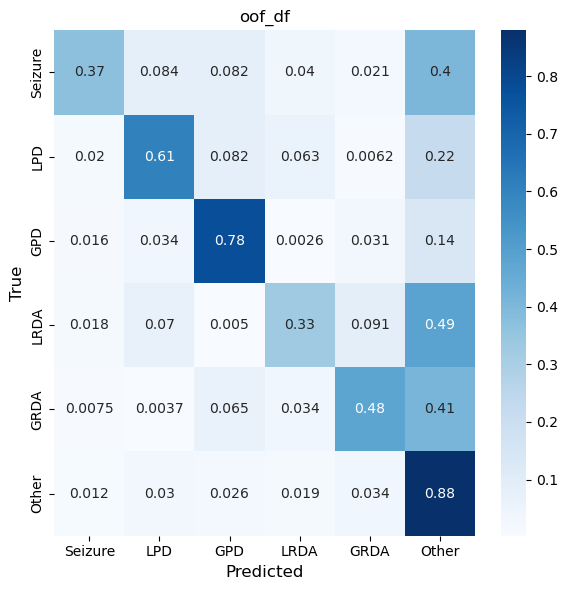

In [44]:
csv_path = "./outputs/oof_df.csv"
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

# <b><span style='color:#F1A424'>|</span> Inference</b><a class='anchor' id='train'></a> [↑](#top) 

***

In [ ]:
model_weights = [x for x in glob("/kaggle/input/dual-encoder-v3/*stage_2*.pth")]
model_weights

In [ ]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

def spectrogram_from_eeg(parquet_path, display=False, offset=None):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
#     print(eeg.shape)
    if offset is None:
        middle = (len(eeg)-10_000)//2
        eeg = eeg.iloc[middle:middle+10_000]
    else:
        eeg = eeg.iloc[offset:offset+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean() < 1: 
                x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
#             plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
#         plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

In [ ]:
test_df = pd.read_csv(paths.TEST_CSV)
print('Test shape',test_df.shape)
test_df.head()

In [ ]:
# READ ALL SPECTROGRAMS
paths_spectrograms = glob(paths.TEST_SPECTROGRAMS + "*.parquet")
print(f'There are {len(paths_spectrograms)} spectrogram parquets')
all_spectrograms = {}

for file_path in tqdm(paths_spectrograms):
    aux = pd.read_parquet(file_path)
    name = int(file_path.split("/")[-1].split('.')[0])
    all_spectrograms[name] = aux.iloc[:,1:].values
    del aux
    
if config.VISUALIZE:
    idx = np.random.randint(0, len(paths_spectrograms))
    spectrogram_path = paths_spectrograms[idx]
    plot_spectrogram(spectrogram_path)

# READ ALL EEG SPECTROGRAMS
print(f"{'-'*10}\nReading All EEG Spectrograms\n{'-'*10}")
paths_eegs = glob(os.path.join(paths.TEST_EEGS, "*.parquet"))
print(f'There are {len(paths_eegs)} EEG spectrograms')
all_eegs_spec = {}
counter = 0

for file_path in tqdm(paths_eegs):
    eeg_id = file_path.split("/")[-1].split(".")[0]
    eeg_spectrogram = spectrogram_from_eeg(file_path, counter < 0)
    all_eegs_spec[int(eeg_id)] = eeg_spectrogram
    counter += 1
    

In [ ]:
test_eeg_parquet_paths = glob(CFG.test_eeg + "*.parquet")
test_eeg_df = pd.read_parquet(test_eeg_parquet_paths[0])
test_eeg_features = test_eeg_df.columns
print(f"There are {len(test_eeg_features)} raw eeg features")
print(list(test_eeg_features))
del test_eeg_df
_ = gc.collect()

# %%time
all_eegs = {}
eeg_ids = test_df.eeg_id.unique()
for i, eeg_id in tqdm(enumerate(eeg_ids)):
    # Save EEG to Python dictionary of numpy arrays
    eeg_path = CFG.test_eeg + str(eeg_id) + ".parquet"
    data = eeg_from_parquet(eeg_path)
    all_eegs[eeg_id] = data

In [ ]:
test_spec_dataset = SpecDataset(test_df, config, all_spectrograms, all_eegs_spec, mode="test")
test_eeg_dataset = EEGDataset(
        df=test_df,
        batch_size=CFG.batch_size,
        mode="test",
        eegs=all_eegs,
        bandpass_filter=model_block['bandpass_filter']
    )

test_dataset = CustomDataset(test_spec_dataset, test_eeg_dataset)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False
)

eeg_X, eeg_y, spec_X, spec_y = test_dataset[0]
print(f"EEG X shape: {eeg_X.shape}")
print(f"EEG y shape: {eeg_y.shape}")
print(f"Spectrogram X shape: {spec_X.shape}")
print(f"Spectrogram y shape: {spec_y.shape}")

In [ ]:
def inference_function(test_loader, model, device):
    model.eval()
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    with tqdm(test_loader, unit="test_batch", desc='Inference') as tqdm_test_loader:
        for step, (eeg_X, eeg_y, spec_X, spec_y) in enumerate(tqdm_test_loader):
            eeg_X = eeg_X.to(device)
            spec_X = spec_X.to(device)
            eeg_y = eeg_y.to(device)
            spec_y = spec_y.to(device)
            y = spec_y
            batch_size = y.size(0)
            with torch.no_grad():
                y_preds = model(eeg_X, spec_X)
            y_preds = softmax(y_preds)
            preds.append(y_preds.to('cpu').numpy()) 
                
    prediction_dict["predictions"] = np.concatenate(preds) 
    return prediction_dict

In [ ]:
predictions = []

for model_weight in model_weights:
    test_spec_dataset = SpecDataset(test_df, config, all_spectrograms, all_eegs_spec, mode="test")
    test_eeg_dataset = EEGDataset(
        df=test_df,
        batch_size=CFG.batch_size,
        mode="test",
        eegs=all_eegs,
        bandpass_filter=model_block['bandpass_filter']
    )

    test_dataset = CustomDataset(test_spec_dataset, test_eeg_dataset)
    train_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True, drop_last=False
    )
    eeg_model = EEGNet(
        kernels=CFG.kernels,
        in_channels=CFG.in_channels,
        fixed_kernel_size=CFG.fixed_kernel_size,
        num_classes=CFG.target_size,
        linear_layer_features=CFG.linear_layer_features,
    )
    spec_model = SpecModel(config, pretrained=False)
    model = CombineModel(eeg_model, spec_model)
    checkpoint = torch.load(model_weight)
    model.load_state_dict(checkpoint["model"])
    # model = torch.load(model_weight)
    model.to(device)
    prediction_dict = inference_function(test_loader, model, device)
    predictions.append(prediction_dict["predictions"])
    torch.cuda.empty_cache()
    gc.collect()
    
predictions = np.array(predictions)
predictions = np.mean(predictions, axis=0)

In [ ]:
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
sub = pd.DataFrame({'eeg_id': test_df.eeg_id.values})
sub[TARGETS] = predictions
sub.to_csv('submission.csv',index=False)
print(f'Submissionn shape: {sub.shape}')
sub.head()

In [ ]:
sub[TARGETS].sum(axis=1)